In [ ]:
import numpy as np
from itertools import combinations
from collections import defaultdict
import pickle
import cupy as cp
import matplotlib.pyplot as plt
import math
from sklearn.datasets import fetch_openml

In [ ]:
def save_checkpoint(path, k, prev_layer, p_emp, d,X):
    ckpt = {
        "k": k,
        "atoms": prev_layer.atoms if prev_layer else [],
        "q": prev_layer.q if prev_layer else None,
        "p_emp": p_emp,
        "imp": prev_layer.importances if prev_layer else [],
        "d": d,
        "X":X
    }
    with open(path, "wb") as f:
        pickle.dump(ckpt, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_checkpoint(path):
    with open(path, "rb") as f:
        ckpt = pickle.load(f)
    return ckpt

In [ ]:

# ============================================================
# GPU Backend: Vectorized & Batched
# ============================================================

GLOBAL_H_CACHE = {}   # key: tuple T, value: float H(T)

# ============================================================
# GPU Backend: Vectorized & Safe Micro-Batching
# ============================================================
def compute_entropy_batch(X_gpu, subsets_list):
    """
    Computes entropy for M subsets simultaneously.
    """
    M = len(subsets_list)
    N = X_gpu.shape[0]
    if M == 0:
        return cp.array([], dtype=cp.float32)

    k = len(subsets_list[0])

    MAX_BATCH = 4096
    
    if M > MAX_BATCH:
        results = []
        for i in range(0, M, MAX_BATCH):
            batch_subsets = subsets_list[i : i + MAX_BATCH]
            results.append(compute_entropy_batch(X_gpu, batch_subsets))
        return cp.concatenate(results)

    subset_indices = cp.array(subsets_list, dtype=cp.int32) # (M, k)
    flat_indices = subset_indices.ravel()
    
    extracted = X_gpu[:, flat_indices]
    data_batch = extracted.reshape(N, M, k).transpose(1, 0, 2)
    
    shifts = (1 << cp.arange(k, dtype=cp.int32)) 
    codes = cp.tensordot(data_batch, shifts, axes=([2], [0])) 
    
    max_code = 1 << k
    offsets = cp.arange(M, dtype=cp.int32) * max_code
    codes_shifted = codes + offsets[:, None]
    
    total_bins = M * max_code
    counts_flat = cp.bincount(codes_shifted.ravel(), minlength=total_bins)
    counts = counts_flat.reshape(M, max_code)
    
    probs = counts.astype(cp.float32) / N
    log_probs = cp.log(probs + 1e-30) 
    log_probs[probs == 0] = 0.0
    plogp = probs * log_probs
    entropies = -cp.sum(plogp, axis=1)
    
    return entropies

def compute_J_gpu(X, atoms):
    """
    Vectorized J computation with micro-batching.
    """
    if not atoms:
        return {}

    k = len(atoms[0])
    X_gpu = cp.asarray(X, dtype=cp.int8)

    needed_set = set()
    atom_structure = {}
    
    needed_by_len = defaultdict(list)

    for S in atoms:
        parts = []
        for r in range(1, k + 1):
            sign = (-1) ** (k - r)
            for T in combinations(S, r):
                parts.append((sign, T))
                if T not in GLOBAL_H_CACHE:
                    needed_set.add(T)
        atom_structure[S] = parts
    
    for T in needed_set:
        needed_by_len[len(T)].append(T)

    for length, subsets in needed_by_len.items():
        if not subsets: continue
            
        entropies_gpu = compute_entropy_batch(X_gpu, subsets)
        
        # Get results
        entropies_cpu = entropies_gpu.get()
        
        # Fill Cache
        for T, val in zip(subsets, entropies_cpu):
            GLOBAL_H_CACHE[T] = float(val)

    # 3. Assemble J on CPU
    J = {}
    for S, parts in atom_structure.items():
        val = 0.0
        for sign, T in parts:
            val += sign * GLOBAL_H_CACHE[T]
        J[S] = val

    return J



def KL(p, q):
    mask = p > 0
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

class LazyMarginals:
    def __init__(self, states):
        self.states = states
        self.cache = {}
    def get(self, S):
        if S not in self.cache:
            idx = np.array([tuple(s[i] for i in S) for s in self.states])
            _, inv = np.unique(idx, axis=0, return_inverse=True)
            self.cache[S] = inv
        return self.cache[S]

def project_incremental(states, p, S, lazy_marginals, q_init, n_sweeps=3):
    q = q_init.copy()
    idx = lazy_marginals.get(S)
    for _ in range(n_sweeps):
        p_m = np.bincount(idx, weights=p)
        q_m = np.bincount(idx, weights=q)
        ratio = np.ones_like(p_m)
        mask = q_m > 0
        ratio[mask] = p_m[mask] / q_m[mask]
        q *= ratio[idx]
        q /= q.sum()
    return q

class EntropyCache:
    def __init__(self, X):
        self.X = X
        self.cache = {}
    def H(self, S):
        # Fallback CPU cache if needed elsewhere
        if S not in self.cache:
            vals, counts = np.unique(self.X[:, S], axis=0, return_counts=True)
            p = counts / counts.sum()
            self.cache[S] = -np.sum(p * np.log(p + 1e-12))
        return self.cache[S]

class SupportCache:
    def __init__(self, X):
        self.X = X
        self.cache = {}
    def support(self, S):
        if S not in self.cache:
            self.cache[S] = np.mean(np.prod(self.X[:, S], axis=1))
        return self.cache[S]



In [ ]:

# ============================================================
# Hierarchical Layer 
# ============================================================

class Layer:
    def __init__(self, k, sigma, tau, prev_layer=None, d=None, mode="proxy"):
        self.k = k
        self.sigma = sigma
        self.tau = tau
        self.prev_layer = prev_layer
        self.d = d if d is not None else prev_layer.d
        self.mode = mode
        self.atoms = []
        self.importances = {}
        self.I = 0.0
        self.q = None

    def build(self, X_gpu, states, p_emp, lazy_marginals, entropy_cache, support_cache):

        # Previous model state
        if self.prev_layer is None:
            D_prev = []
            q_prev = np.ones_like(p_emp) / len(p_emp)
        else:
            D_prev = list(self.prev_layer.atoms)
            q_prev = self.prev_layer.q



        # Candidate generation
        candidates = self._generate_candidates(D_prev)
        
        print(f"k={self.k} | Candidates: {len(candidates)}")

        # Frequency pruning
        supports = np.array([support_cache.support(S) for S in candidates])
        if len(supports) == 0:
            self.q = q_prev
            return self
        
        if self.sigma is None:
            self.sigma = np.quantile(supports, 0.5)
            print(f"k={self.k} | Adaptive sigma set to median: {self.sigma:.4e}")
        
        candidates = [
            S for S, sup in zip(candidates, supports)
            if sup >= self.sigma
        ]
        print(f"k={self.k} | After freq prune: {len(candidates)}")

      

       
    
        print(f"k={self.k} | After spatial prune: {len(candidates)}")

        if not candidates:
            self.q = q_prev
            return self

        # ----------------------------------------------------
        # VECTORIZED GPU COMPUTATION OF J
        # ----------------------------------------------------
        J = compute_J_gpu(X_gpu, candidates)
        # ----------------------------------------------------

        vals = np.abs(np.fromiter(J.values(), dtype=float))
        if len(vals) > 0:
            print(f"J Stats: Max={vals.max():.4f}, Median={np.median(vals):.4f}")

        vals = np.abs(np.fromiter(J.values(), dtype=float))
        if len(vals) == 0:
            self.q = q_prev
            return self
        
        # J_median = np.median(vals)

        # ---------- ADAPTIVE TAU ----------
        vals = np.abs(np.fromiter(J.values(), dtype=float))
        if self.tau is None:
            self.tau = np.quantile(vals, 0.75)

            
        print(f"k={self.k} | Adaptive tau set to median: {self.tau:.4e}")

        # Screening
        screened = [S for S in candidates if abs(J[S]) >= self.tau]
        if not screened:
            self.q = q_prev
            return self

        screened.sort(key=lambda S: abs(J[S]), reverse=True)

        current_atoms = []
        current_q = q_prev

        for S in screened:
            if self.mode == "proxy":
                RI = abs(J[S])
            else:
                q_trial = project_incremental(states, p_emp, S, lazy_marginals, current_q)
                RI = KL(q_trial, current_q)

            if RI < self.tau:
                break

            current_atoms.append(S)
            self.importances[S] = RI
            self.I += RI

            if self.mode == "exact":
                current_q = q_trial

        self.atoms = current_atoms
        self.q = current_q
        return self

    def _generate_candidates(self, prev_atoms):
        if self.k == 1:
            return [(i,) for i in range(self.d)]
        
        buckets = defaultdict(list)
        for A in prev_atoms:
            for T in combinations(A, self.k - 2):
                buckets[T].append(A)
        C = set()
        for group in buckets.values():
      
            for A, B in combinations(group, 2):

                
                S = tuple(sorted(set(A) | set(B)))
                
                
                if len(S) == self.k:
                    C.add(S)
                
        return list(C)

In [ ]:
# 6. Visualization
def plot_atoms_by_order(layers, grid_shape=(28, 28), max_atoms=40):
    for k, layer in layers.items():
        atoms = layer.atoms[:max_atoms]
        if not atoms: continue
        
        n = len(atoms)
        n_cols = min(10, n)
        n_rows = math.ceil(n / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5*n_cols, 1.5*n_rows))
        if n == 1: axes = np.array([axes])
        
        for ax, S in zip(axes.flat, atoms):
            img = np.zeros(grid_shape[0]*grid_shape[1])
            img[list(S)] = 1
            ax.imshow(img.reshape(grid_shape), cmap="gray")
            ax.axis("off")
        
        for ax in axes.flat[n:]: ax.axis("off")
        fig.suptitle(f"Layer k={k} ({len(layer.atoms)} atoms)")
        plt.show()

def plot_layer_atoms(layers, k, grid_shape=(28, 28), max_atoms=40):
    if k not in layers:
        raise KeyError(f"Layer k={k} not found.")

    layer = layers[k]
    atoms = layer.atoms[:max_atoms]

    if not atoms:
        print(f"Layer k={k} has no atoms.")
        return

    n = len(atoms)
    n_cols = min(10, n)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(1.5 * n_cols, 1.5 * n_rows)
    )

    if n == 1:
        axes = np.array([axes])

    for ax, S in zip(axes.flat, atoms):
        img = np.zeros(grid_shape[0] * grid_shape[1])
        img[list(S)] = 1
        ax.imshow(img.reshape(grid_shape), cmap="gray")
        ax.axis("off")
        imp = layer.importances.get(S, 0.0)
        ax.set_title(f"I={imp:.2e}, |S|={len(list(S))}", fontsize=8)

    for ax in axes.flat[n:]:
        ax.axis("off")

    fig.suptitle(f"Layer k={k} ({len(layer.atoms)} atoms)")
    plt.show()


def plot_layer_atoms_bottom(layers, k, grid_shape=(28, 28), max_atoms=40):
    if k not in layers:
        raise KeyError(f"Layer k={k} not found.")

    layer = layers[k]
    H, W = grid_shape

    row_cut = H // 2 + 4   

    atoms = [
        S for S in layer.atoms
        if all(divmod(idx, W)[0] >= row_cut for idx in S)
    ][:max_atoms]

    if not atoms:
        print(f"Layer k={k} has no atoms fully in the bottom region.")
        return

    n = len(atoms)
    n_cols = min(10, n)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(1.5 * n_cols, 1.5 * n_rows)
    )

    if n == 1:
        axes = np.array([axes])

    for ax, S in zip(axes.flat, atoms):
        img = np.zeros((H, W))
        for idx in S:
            r, c = divmod(idx, W)
            img[r, c] = 1
    
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    
        # ---- ADD IMPORTANCE ----
        imp = layer.importances.get(S, 0.0)
        ax.set_title(f"I={imp:.2e}, |S|={len(list(S))}", fontsize=8)


    for ax in axes.flat[n:]:
        ax.axis("off")

    fig.suptitle(
        f"Layer k={k} (atoms fully in bottom region, row ≥ {row_cut})"
    )
    plt.show()


def plot_layer_atom_sum(layers, k, grid_shape=(28, 28), normalize=True):
    if k not in layers:
        raise KeyError(f"Layer k={k} not found.")

    layer = layers[k]
    H, W = grid_shape

    if not layer.atoms:
        print(f"Layer k={k} has no atoms.")
        return

    # --------------------------------------------------
    # Accumulate pixel counts
    # --------------------------------------------------
    heat = np.zeros(H * W, dtype=float)

    for S in layer.atoms:
        for idx in S:
            # heat[idx] += 1.0
            heat[idx] += layer.importances.get(S, 0.0)

    heat = heat.reshape(H, W)

    # if normalize:
    #     heat /= heat.max() if heat.max() > 0 else 1.0

    # --------------------------------------------------
    # Plot
    # --------------------------------------------------
    plt.figure(figsize=(4, 4))
    im = plt.imshow(heat, cmap="hot")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(
        f"Layer k={k} — sum of atoms "
        f"({len(layer.atoms)} atoms)"
    )
    plt.axis("off")
    plt.show()


In [2]:
# 1. Load Data
mnist = fetch_openml("mnist_784", as_frame=False)
X0 = mnist.data
y0 = mnist.target.astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [22]:
# 2. Filter & Preprocess
mask = (y0 == 8) | (y0 == 0) | (y0==7) | (y0==1)
# mask =(y0 == 0) | (y0==3) | (y0==7)
X_small = X0[mask]
y_small = y0[mask]

N = 2000
idx = np.random.choice(len(X_small), N, replace=False)
X_small = X_small[idx]

print(X_small.max())
# Downsample & Binarize
X_imgs = X_small.reshape(-1, 28, 28)
X_bin = (X_imgs > 200).astype(int)
X = X_bin.reshape(len(X_bin), -1)

print("Final Data Shape:", X.shape)

255.0
Final Data Shape: (2000, 784)


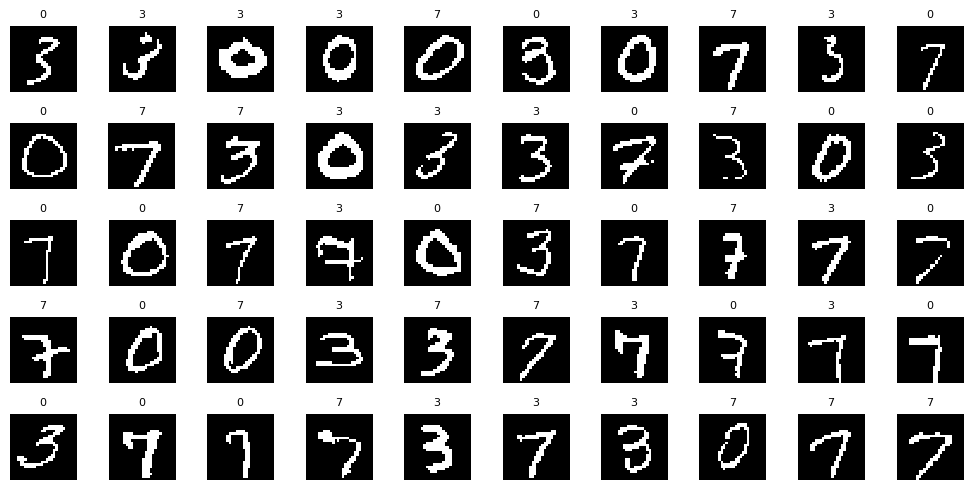

In [ ]:

n_rows, n_cols = 5, 10
n_show = n_rows * n_cols


imgs = X[:n_show].reshape(-1, 28, 28)
labels = y_small[:n_show]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))

for ax, img, lab in zip(axes.flat, imgs, labels):
    ax.imshow(img, cmap="gray", interpolation="nearest")
    ax.set_title(str(lab), fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 3. Setup Caches
states, counts = np.unique(X, axis=0, return_counts=True)
p_emp = counts / counts.sum()
lazy_marginals = LazyMarginals(states)
entropy_cache = EntropyCache(X)
support_cache = SupportCache(X)

X_gpu = cp.asarray(X, dtype=cp.int8)


In [23]:
def KL(p, q):
    mask = p > 0
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))


q_null = np.ones_like(p_emp, dtype=np.float64)
q_null = q_null / q_null.sum()

KL_null = KL(p_emp, q_null)

print(f"KL_support(p_emp || q_nullspace) = {KL_null:.6f}")

q_null,p_emp

KL_support(p_emp || q_nullspace) = 0.000000


(array([0.0005, 0.0005, 0.0005, ..., 0.0005, 0.0005, 0.0005]),
 array([0.0005, 0.0005, 0.0005, ..., 0.0005, 0.0005, 0.0005]))

In [20]:
build_kwargs = dict(
    X_gpu=X_gpu,          # changed
    states=states,
    p_emp=p_emp,
    lazy_marginals=lazy_marginals,
    entropy_cache=entropy_cache,
    support_cache=support_cache,
)

KL_list=[]
D_cum = []


KL_support(p_emp || q_nullspace) = 0.000000


(array([0.0005, 0.0005, 0.0005, ..., 0.0005, 0.0005, 0.0005]),
 array([0.0005, 0.0005, 0.0005, ..., 0.0005, 0.0005, 0.0005]))


--- Building Layer k=1 ---
k=1 | Candidates: 784
k=1 | After freq prune: 493
k=1 | After spatial prune: 493
J Stats: Max=0.6931, Median=0.4438
k=1 | Adaptive tau set to median: 1.0000e-03


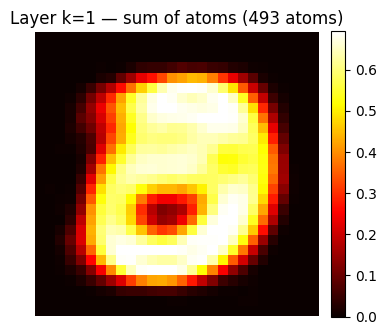


--- Building Layer k=2 ---
k=2 | Candidates: 121278
k=2 | Adaptive sigma set to median: 9.0000e-03
k=2 | After freq prune: 61242
k=2 | After spatial prune: 61242
J Stats: Max=0.3685, Median=0.0040
k=2 | Adaptive tau set to median: 1.0000e-02


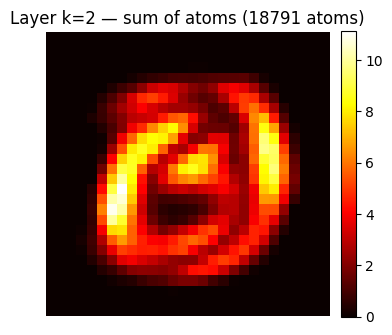


--- Building Layer k=3 ---
k=3 | Candidates: 1470646
k=3 | After freq prune: 158086
k=3 | After spatial prune: 158086
J Stats: Max=0.2567, Median=0.0062
k=3 | Adaptive tau set to median: 5.0000e-02


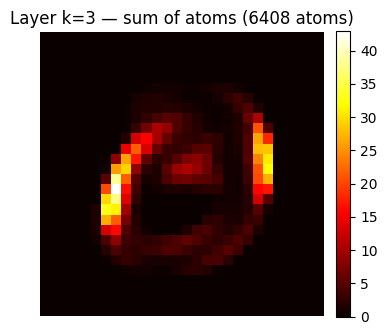

In [ ]:
def KL_support(p_emp, q_vals, eps=1e-15):
    """
    p_emp : (m,) empirical distribution over the m unique observed states
    q_vals: (m,) model probabilities evaluated on the SAME m states (not necessarily normalized)
    returns: KL(p_emp || q_support), where q_support is q renormalized on the empirical support
    """
    p = np.asarray(p_emp, dtype=np.float64)
    q = np.asarray(q_vals, dtype=np.float64)


    Z = q.sum()
    if not np.isfinite(Z) or Z <= 0:
        return np.inf
    q = q / Z


    q = np.clip(q, eps, 1.0)
    q = q / q.sum()

    mask = p > 0
    return np.sum(p[mask] * (np.log(p[mask]) - np.log(q[mask])))


KL_list = []
D_cum = []

layer_params = {
    1: dict(sigma=5e-4, tau=1e-3),
    2: dict(sigma=None, tau=1e-2),
    3: dict(sigma=1e-1, tau=5e-2),
}

layers = {}
prev_layer = None
d = X.shape[1]

q_global = np.ones_like(p_emp, dtype=np.float64) / len(p_emp)

# baseline
KL_prev = KL_support(p_emp, q_global)
KL_list.append(KL_prev)

for k in range(1, 4):
    params = layer_params[k]
    print(f"\n--- Building Layer k={k} ---")

    layer = Layer(
        k=k,
        sigma=params["sigma"],
        # sigma=None,
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    # plot_layer_atoms(layers, k, max_atoms=100)
    # plot_layer_atoms_bottom(layers, k)
    plot_layer_atom_sum(layers, k)

    # # accumulate atoms
    # D_cum.extend(layer.atoms)

    # project incrementally, but DO NOT reinitialize q
    # for S in layer.atoms:
    #     q_global = project_incremental(
    #         states=states,
    #         p=p_emp,
    #         S=S,
    #         lazy_marginals=lazy_marginals,
    #         q_init=q_global,
    #         n_sweeps=5
    #     )

    # KL_curr = KL_support(p_emp, q_global)
    # KL_list.append(KL_curr)

    # print(
    #     f"k={k} | #atoms={len(layer.atoms)} | "
    #     f"I_k={layer.I:.4f} | KL_support={KL_curr:.6f}"
    # )

    # # monotonicity check (up to tiny numerical tolerance)
    # assert KL_curr <= KL_prev + 1e-10
    # KL_prev = KL_curr

    save_checkpoint(f"checkpoint_{k}.pkl", k, prev_layer, p_emp, d, X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break

    prev_layer = layer


In [ ]:
KL_list

In [24]:
layer_params = {
    4: dict(sigma=None, tau=1e-4),
    5: dict(sigma=None, tau=1e-3),
    6: dict(sigma=None, tau=1e-3),
    7: dict(sigma=1e-3, tau=1e-3),
    8: dict(sigma=1e-3, tau=1e-3),
    
    # 14: dict(sigma=1e-4, tau=1e-4),
    # 15: dict(sigma=1e-4, tau=1e-4),
    # 16: dict(sigma=1e-4, tau=1e-4),
    # 17: dict(sigma=1e-4, tau=1e-4),
    # 18: dict(sigma=1e-4, tau=1e-4),
    # 19: dict(sigma=1e-4, tau=1e-4),
    # 20: dict(sigma=1e-4, tau=1e-4)
    # 21: dict(sigma=1e-4, tau=1e-4),
}


--- Building Layer k=4 ---
k=4 | Candidates: 60402
k=4 | Adaptive sigma set to median: 9.7500e-02
k=4 | After freq prune: 30441
k=4 | After spatial prune: 30441
J Stats: Max=0.1908, Median=0.0434
k=4 | Adaptive tau set to median: 1.0000e-04


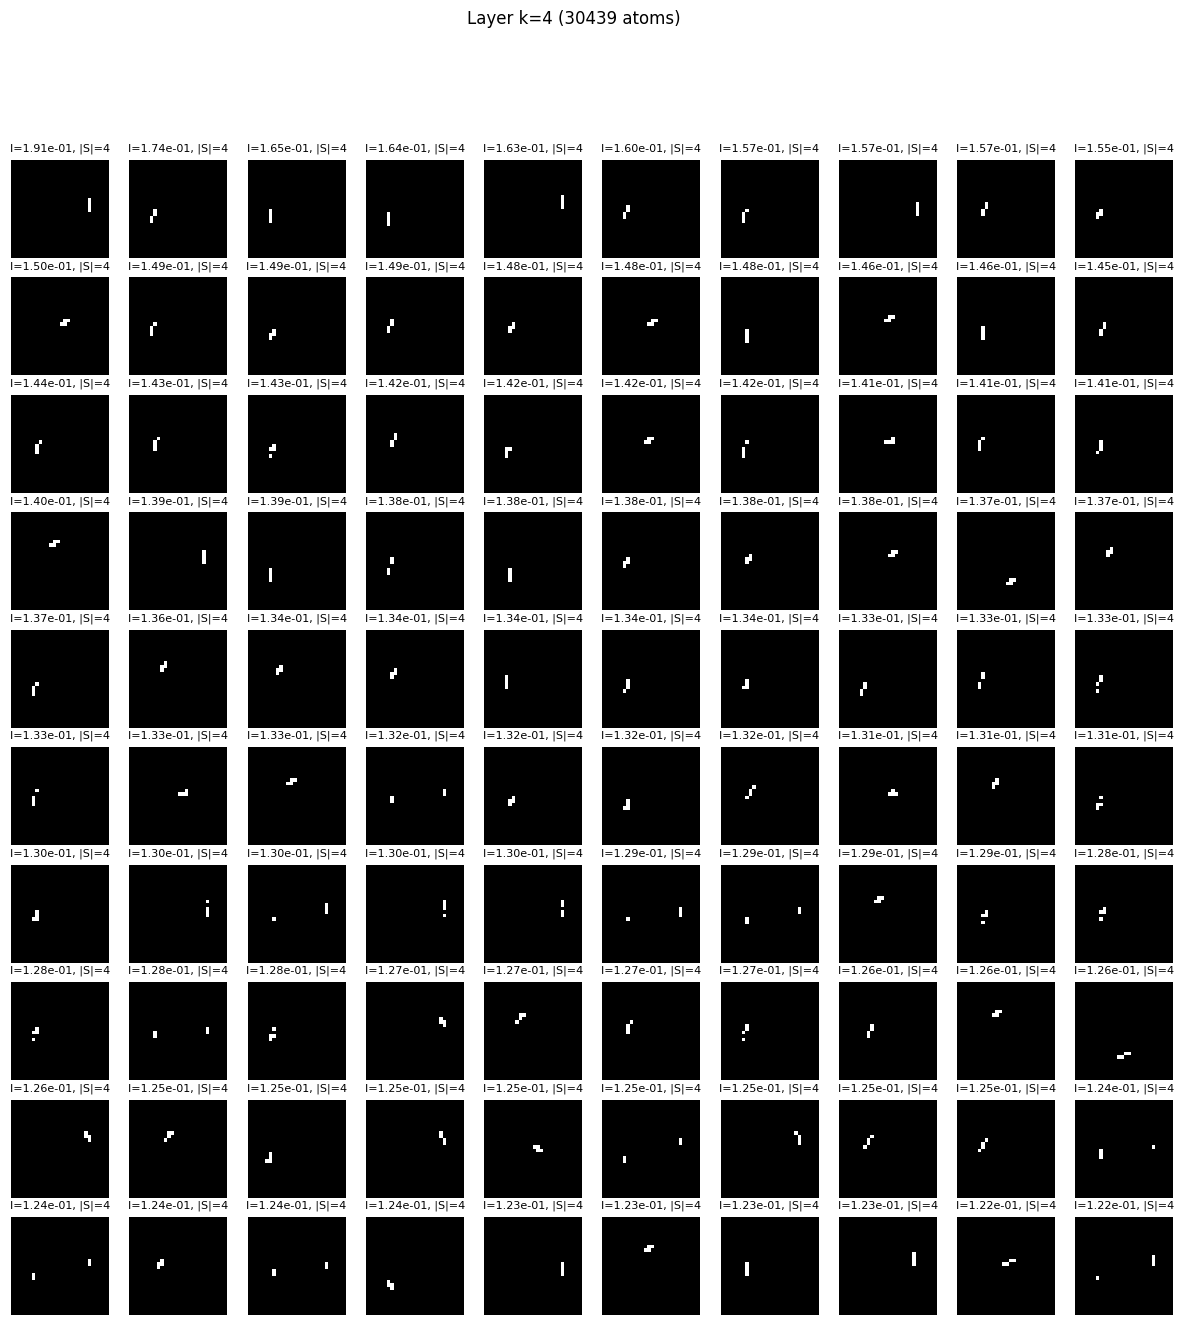

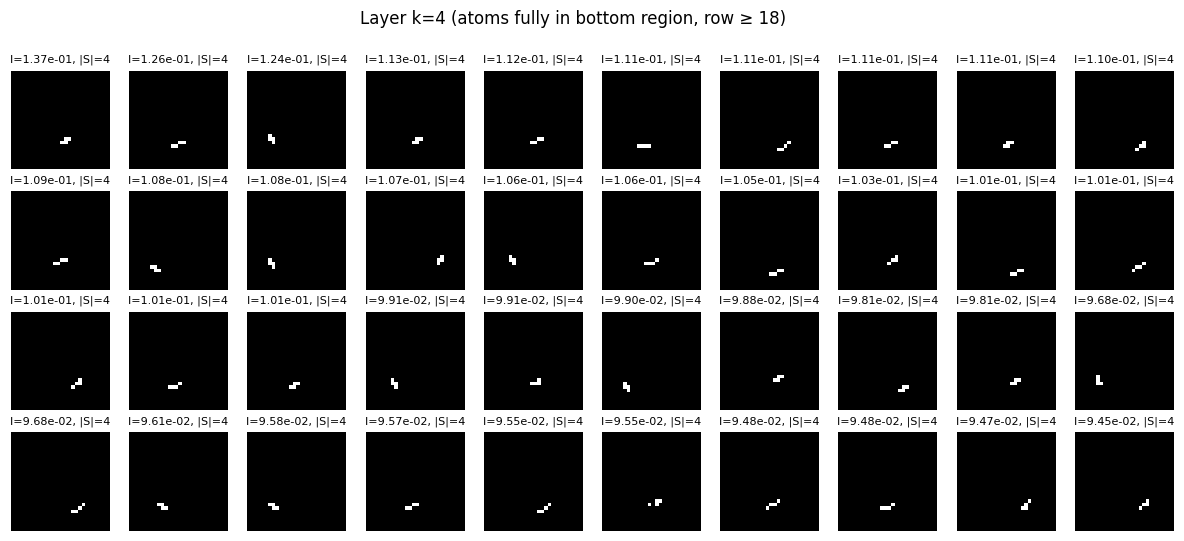

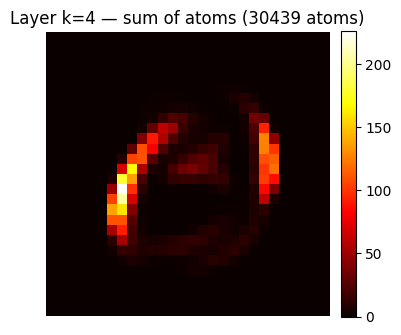

Result: 30439 atoms selected. KL=0.000000

--- Building Layer k=5 ---
k=5 | Candidates: 271057
k=5 | Adaptive sigma set to median: 8.6500e-02
k=5 | After freq prune: 138154
k=5 | After spatial prune: 138154
J Stats: Max=0.1430, Median=0.0296
k=5 | Adaptive tau set to median: 3.8701e-02


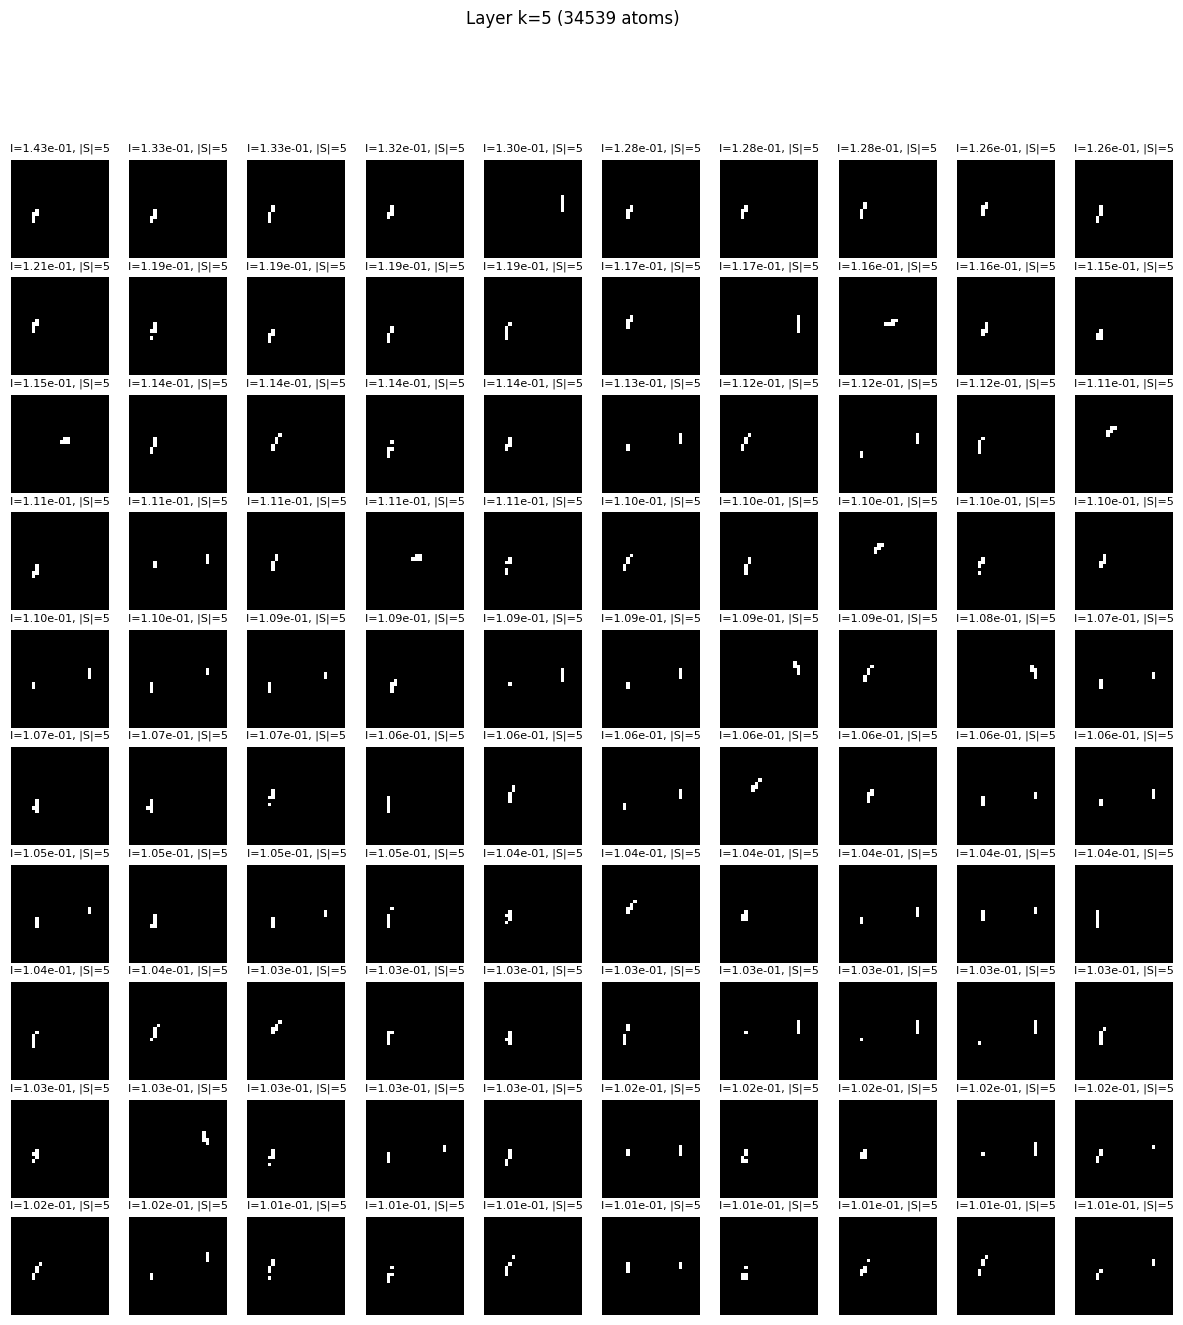

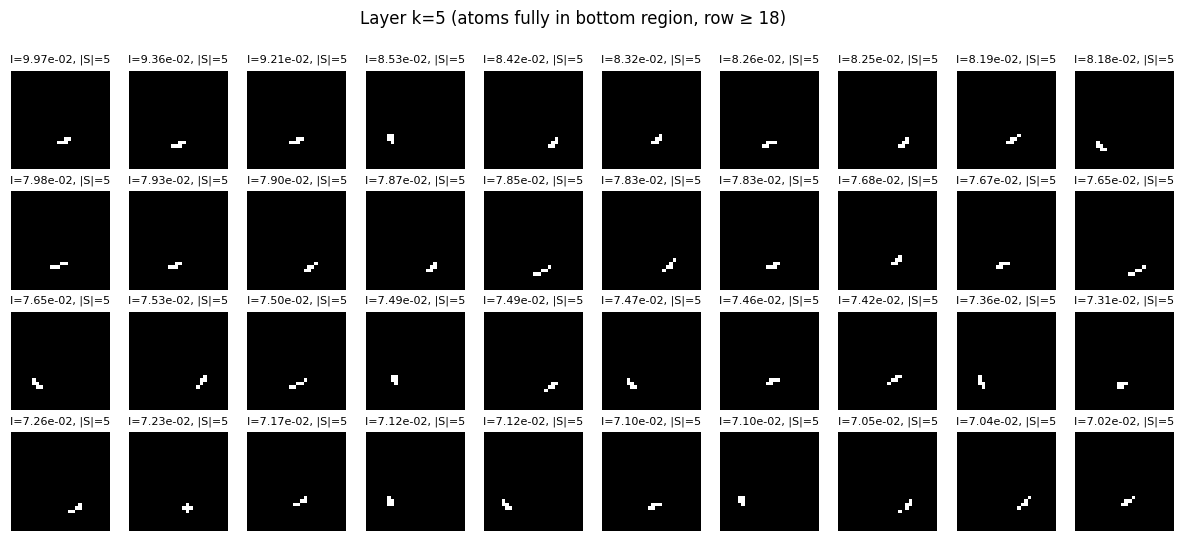

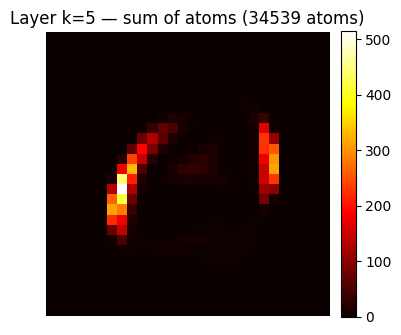

Result: 34539 atoms selected. KL=0.000000

--- Building Layer k=6 ---
k=6 | Candidates: 240383
k=6 | Adaptive sigma set to median: 7.9500e-02
k=6 | After freq prune: 123216
k=6 | After spatial prune: 123216
J Stats: Max=0.1181, Median=0.0346
k=6 | Adaptive tau set to median: 4.0700e-02


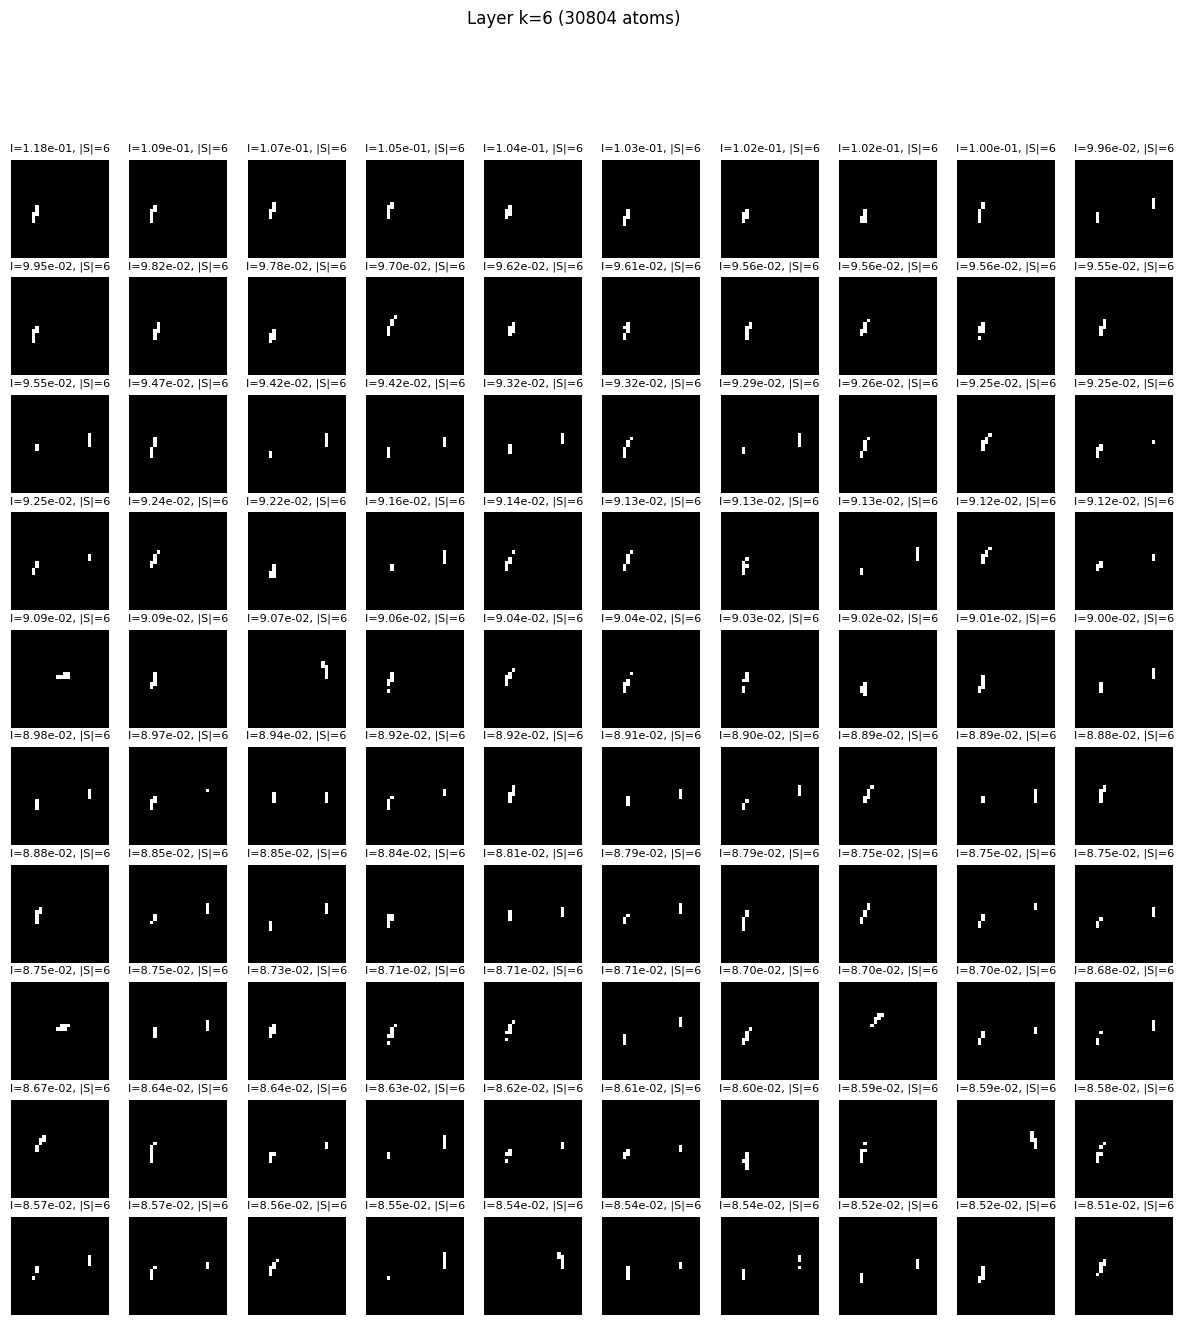

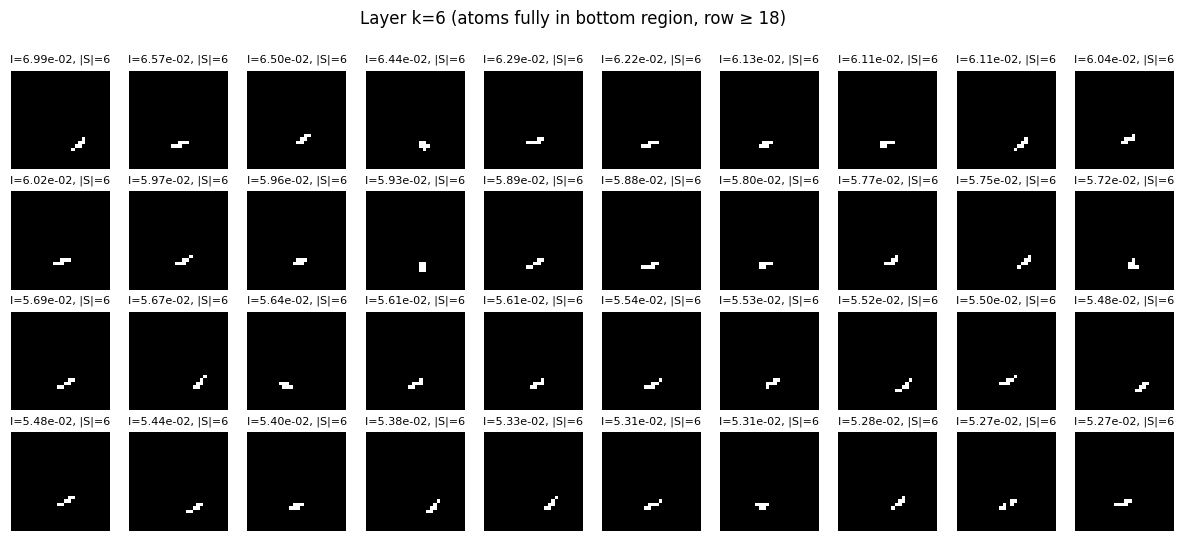

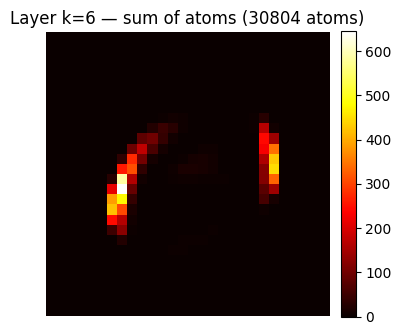

Result: 30804 atoms selected. KL=0.000000

--- Building Layer k=7 ---
k=7 | Candidates: 163125
k=7 | Adaptive sigma set to median: 7.4500e-02
k=7 | After freq prune: 85140
k=7 | After spatial prune: 85140
J Stats: Max=0.0945, Median=0.0364
k=7 | Adaptive tau set to median: 4.1102e-02


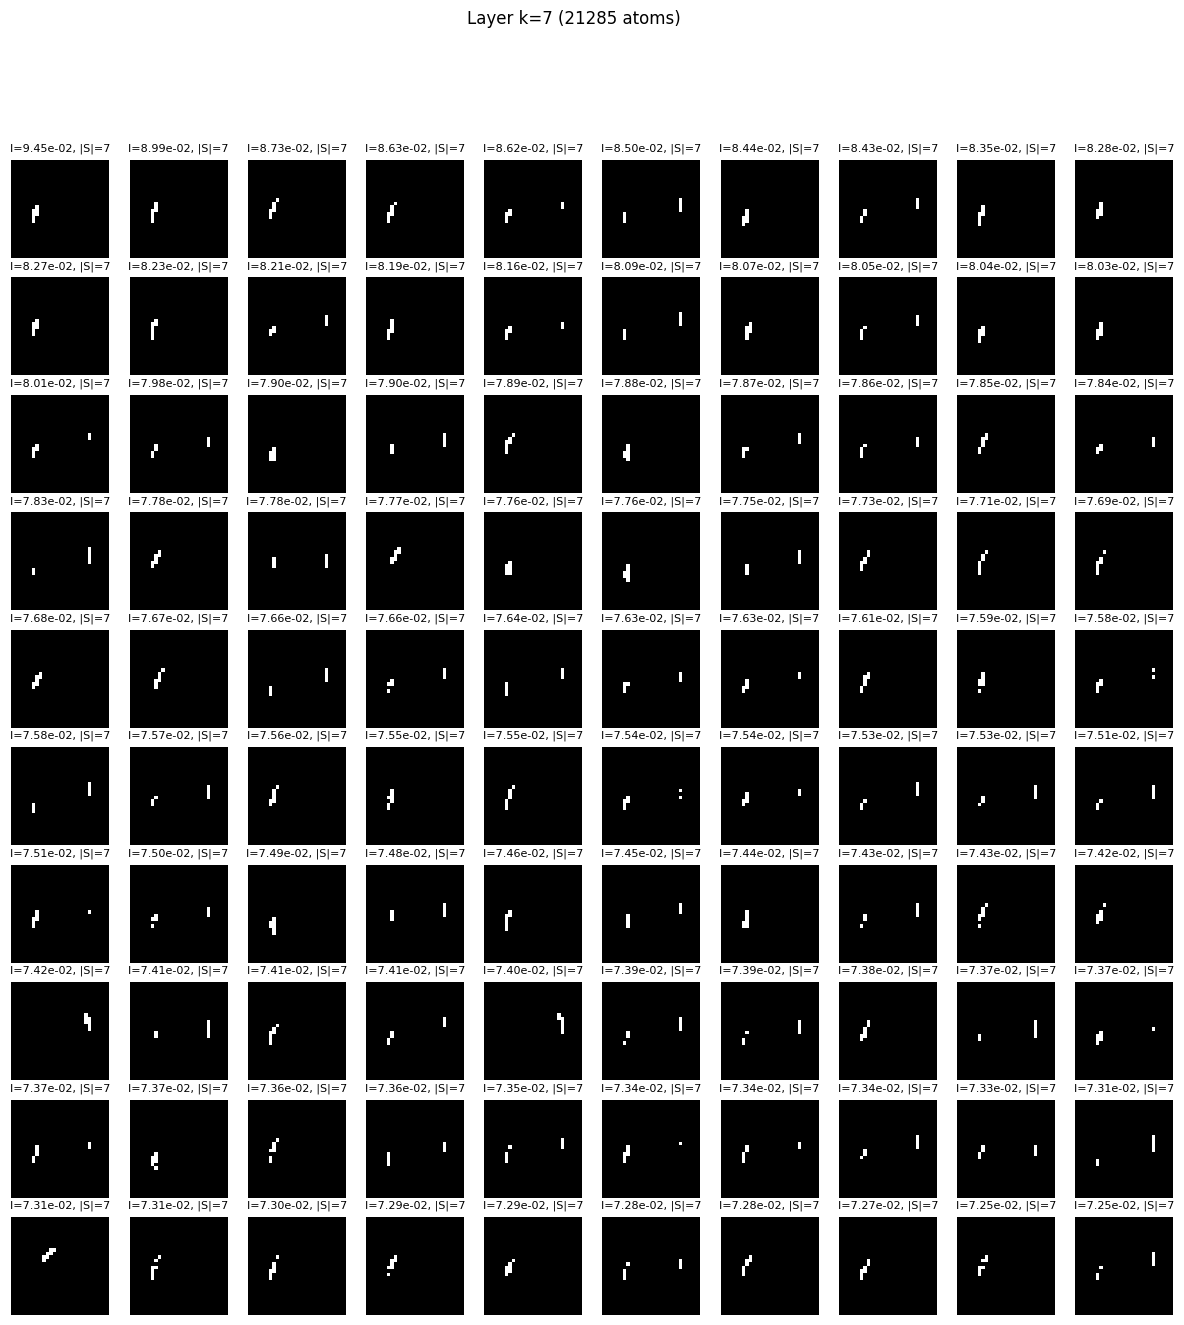

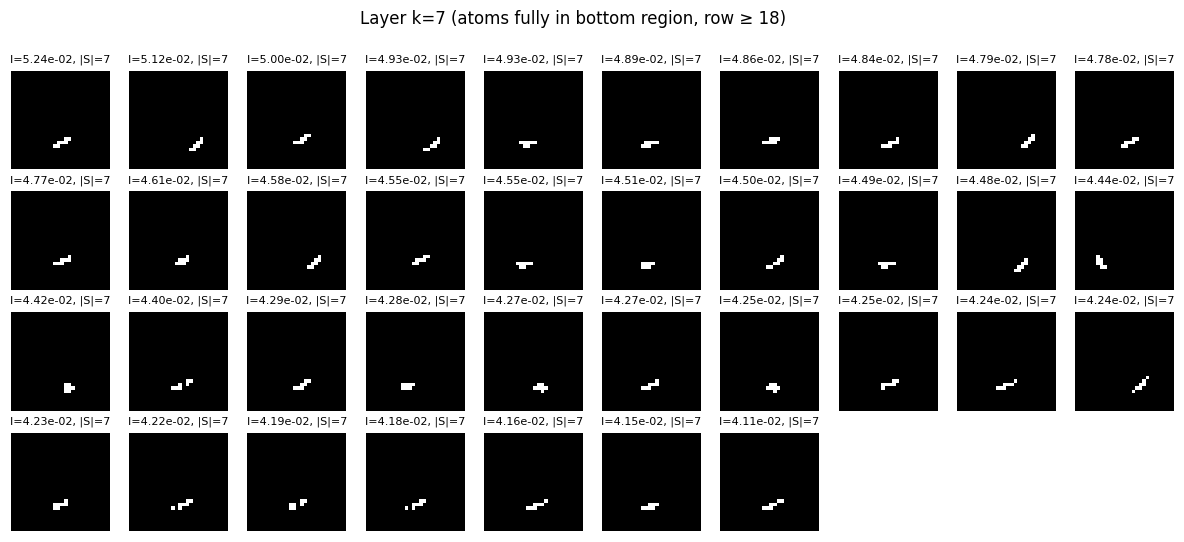

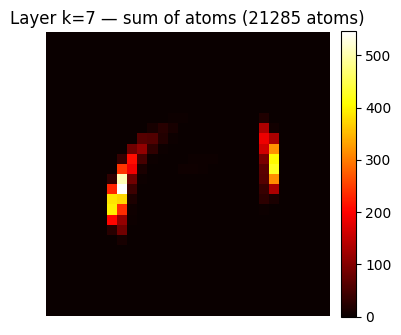

Result: 21285 atoms selected. KL=0.000000

--- Building Layer k=8 ---
k=8 | Candidates: 85512
k=8 | Adaptive sigma set to median: 7.0500e-02
k=8 | After freq prune: 44831
k=8 | After spatial prune: 44831
J Stats: Max=0.0785, Median=0.0372
k=8 | Adaptive tau set to median: 4.1030e-02


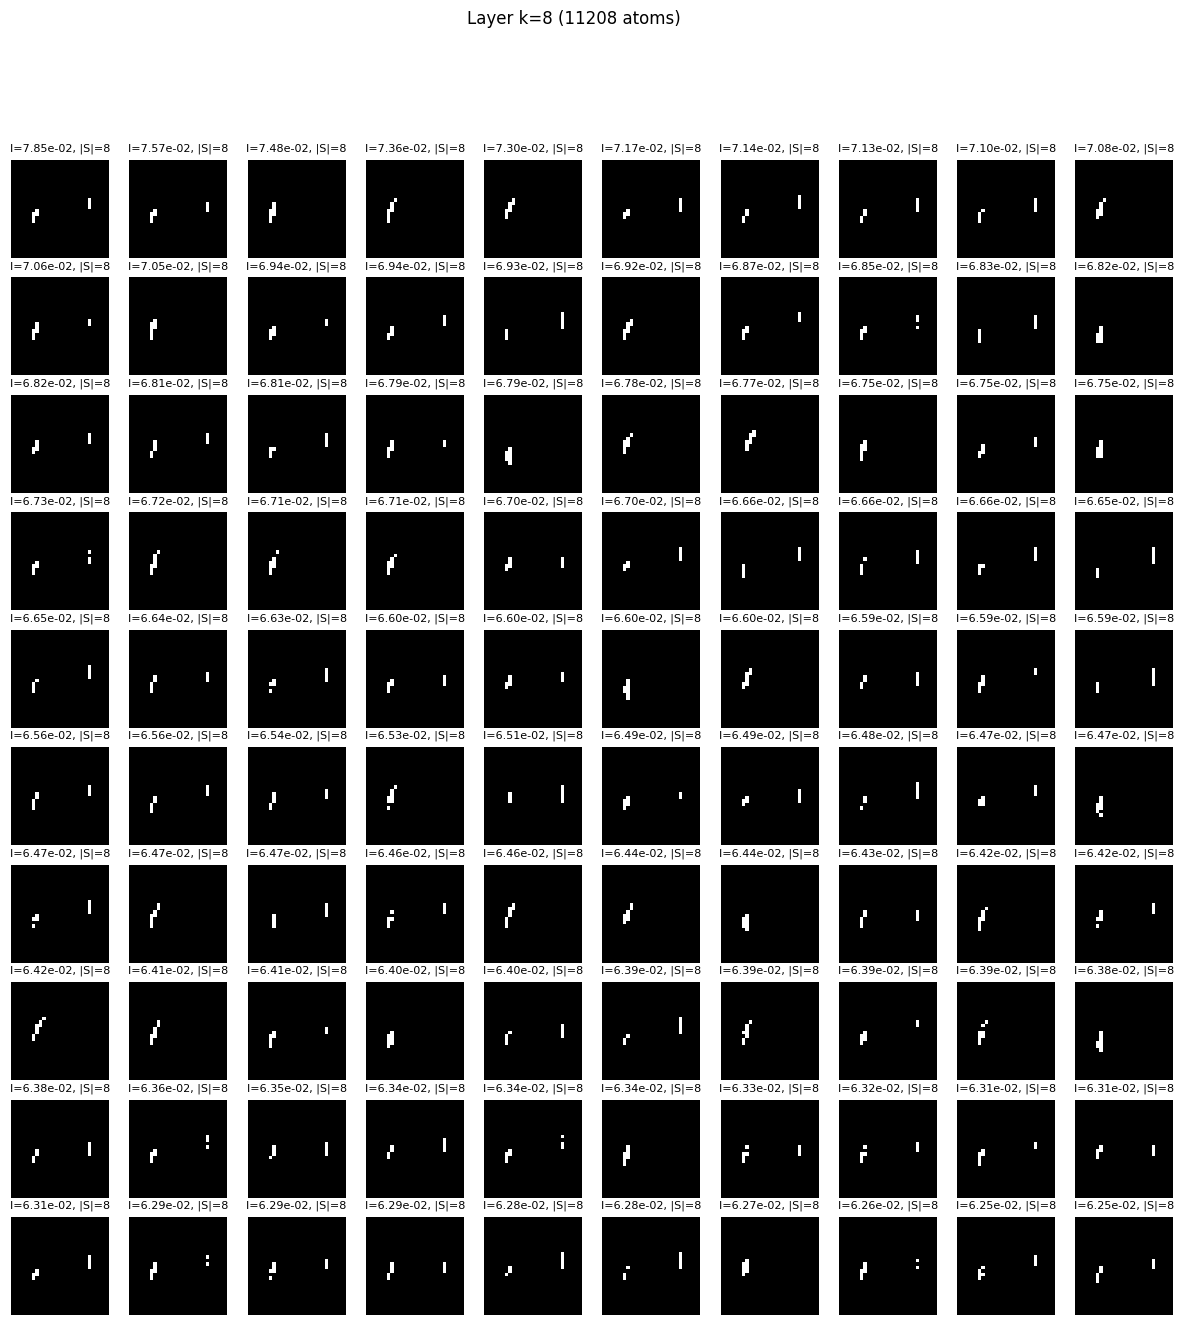

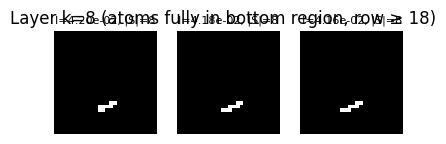

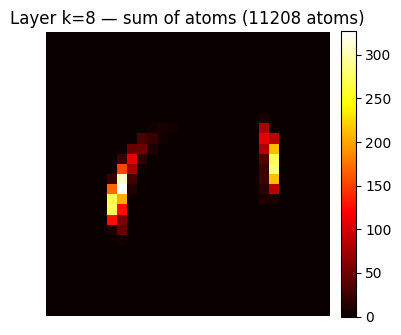

Result: 11208 atoms selected. KL=0.000000


In [25]:
prev_layer=layers[3]
for k in range(4,9):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")

    if k==4:
        layer = Layer(
            k=k,
            # sigma=params["sigma"],
            # tau=params["tau"],
            sigma=params["sigma"],
            tau=params["tau"],
            
            prev_layer=prev_layer,
            d=d if prev_layer is None else None
        ).build(**build_kwargs)
    else:
        layer = Layer(
            k=k,
            # sigma=params["sigma"],
            # tau=params["tau"],
            sigma=None,
            tau=None,
            prev_layer=prev_layer,
            d=d if prev_layer is None else None
        ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    plot_layer_atom_sum(layers, k)
    
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint(f"checkpoint_{k}.pkl", k, prev_layer, p_emp, d,X)
    

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer


    

In [32]:
# ckpt = load_checkpoint("checkpoint.pkl")
# prev_layer = Layer(
#     k=ckpt["k"],
#     sigma=0.0,      # not used anymore
#     tau=0.0,
#     prev_layer=None,
#     d=ckpt["d"]
# )

# prev_layer.atoms = ckpt["atoms"]
# prev_layer.q = ckpt["q"]

# X = ckpt["X"]
# print(X)
# states, counts = np.unique(X, axis=0, return_counts=True)
# p_emp = ckpt["p_emp"]

# lazy_marginals = LazyMarginals(states)
# entropy_cache  = EntropyCache(X)
# support_cache  = SupportCache(X)

# build_kwargs = dict(
#     X=X,
#     states=states,
#     p_emp=p_emp,
#     lazy_marginals=lazy_marginals,
#     entropy_cache=entropy_cache,
#     support_cache=support_cache,
# )



--- Building Layer k=9 ---
k=9 | Candidates: 35044
k=9 | After freq prune: 35044
k=9 | After spatial prune: 35044
J Stats: Max=0.0684, Median=0.0358
k=9 | Adaptive tau set to median: 5.0000e-02


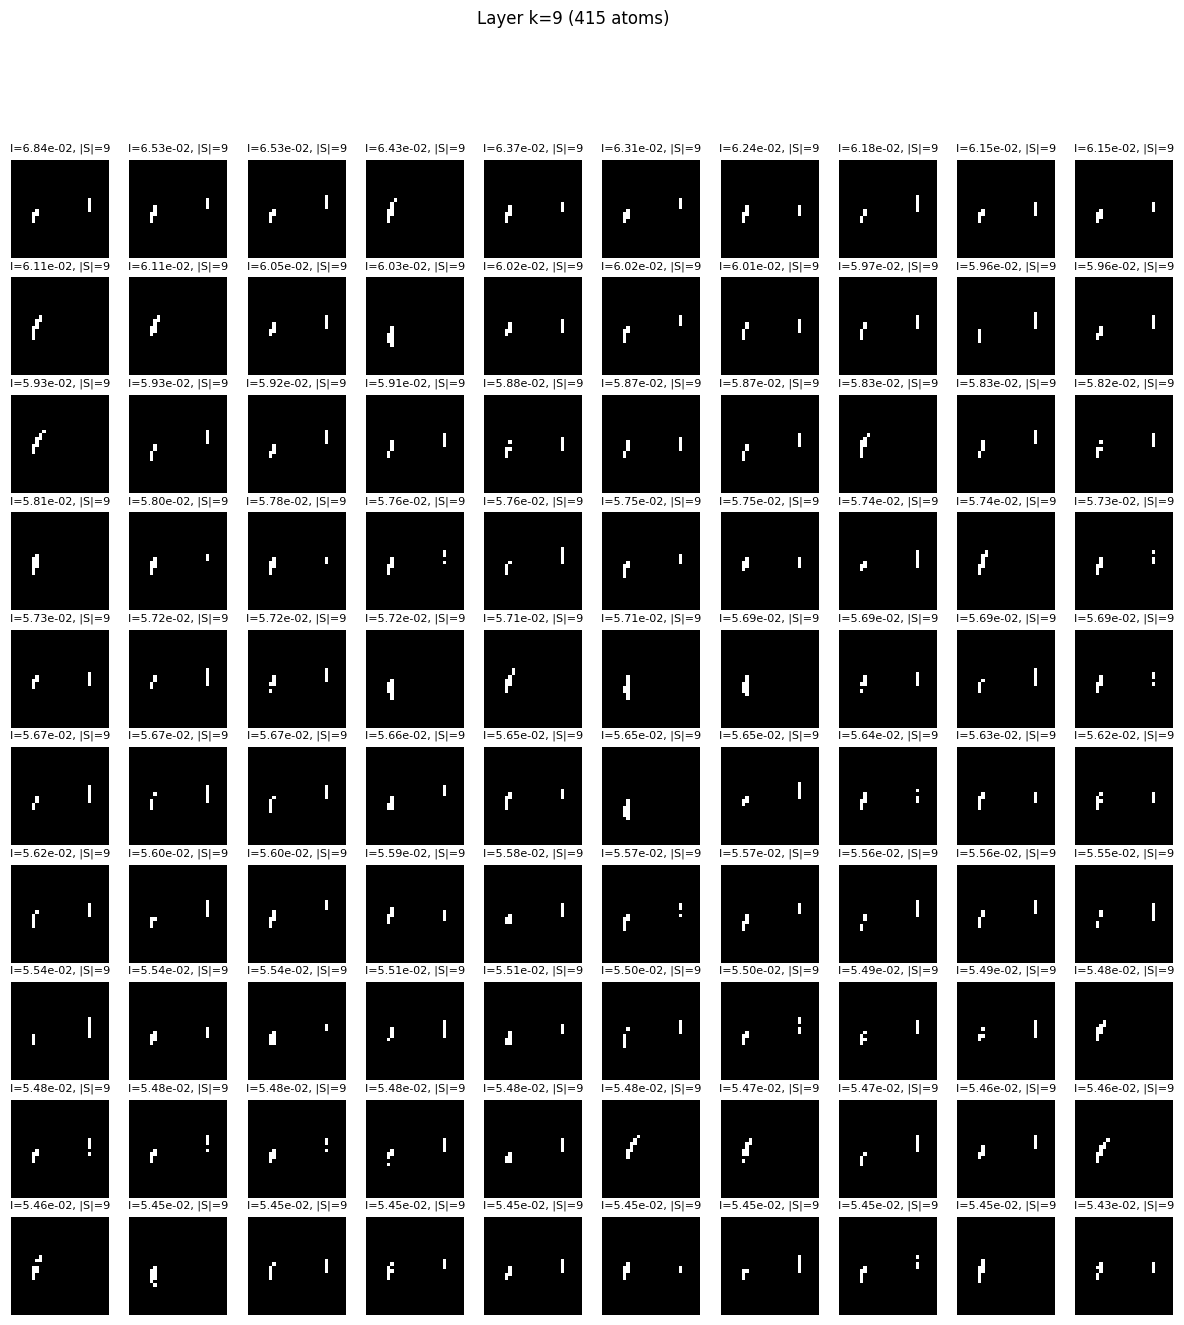

Layer k=9 has no atoms fully in the bottom region.
Result: 415 atoms selected. KL=0.000000

--- Building Layer k=10 ---
k=10 | Candidates: 678
k=10 | After freq prune: 678
k=10 | After spatial prune: 678
J Stats: Max=0.0581, Median=0.0435
k=10 | Adaptive tau set to median: 1.0000e-02


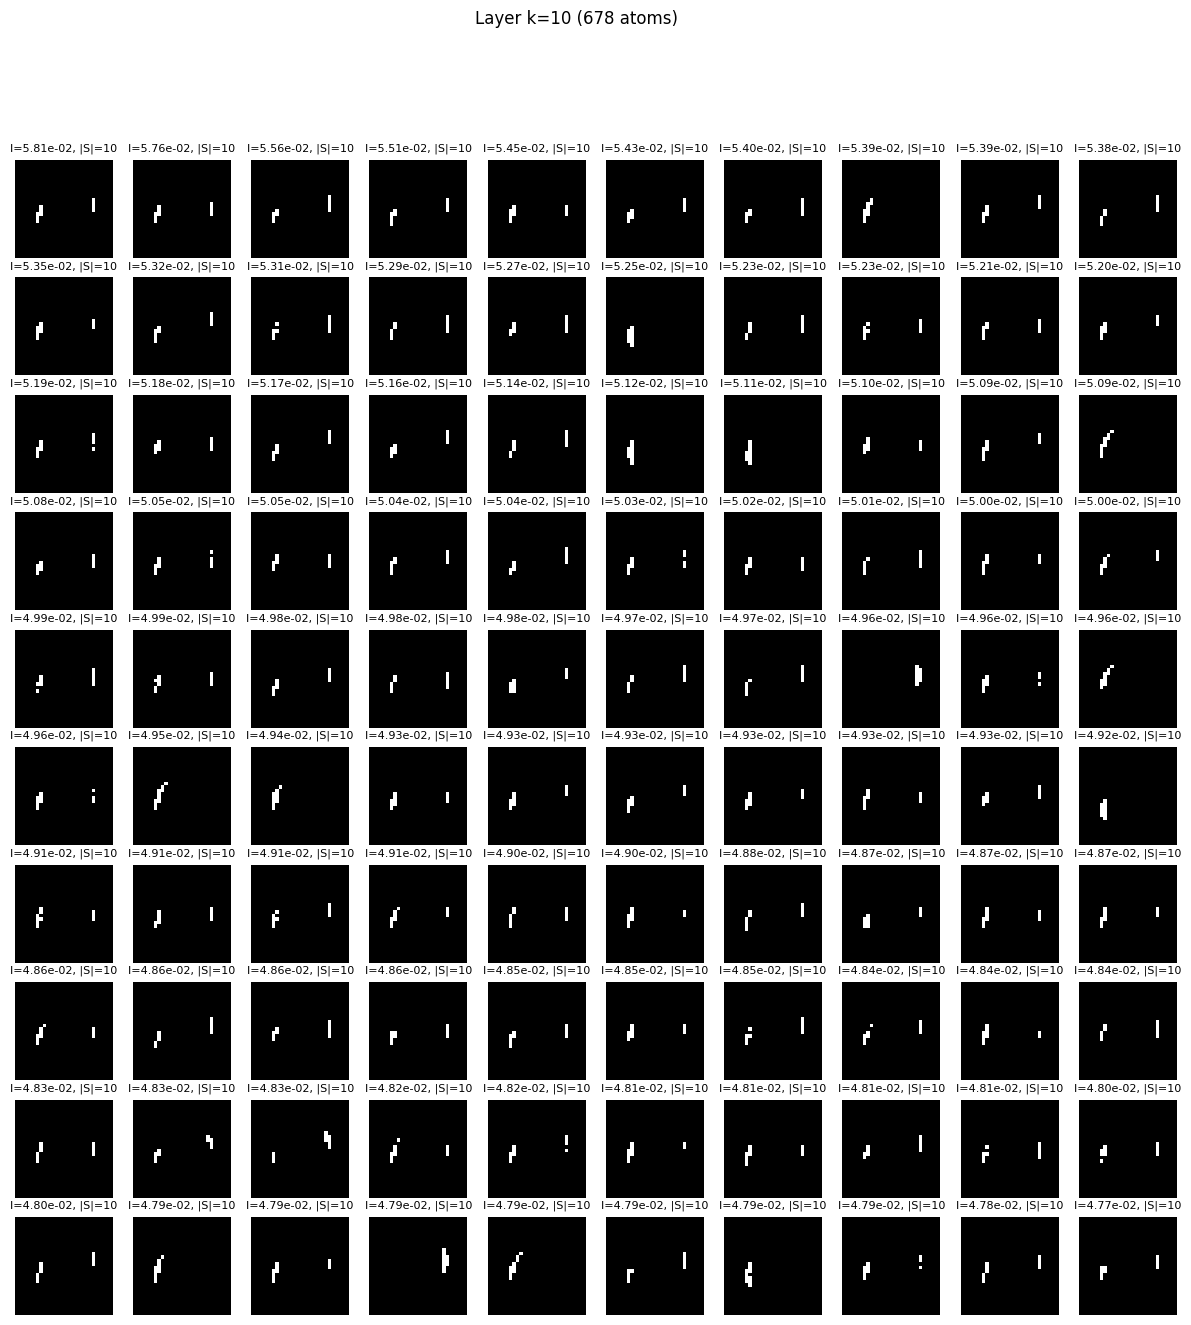

Layer k=10 has no atoms fully in the bottom region.
Result: 678 atoms selected. KL=0.000000

--- Building Layer k=11 ---
k=11 | Candidates: 1195
k=11 | After freq prune: 1195
k=11 | After spatial prune: 1195
J Stats: Max=0.0504, Median=0.0350
k=11 | Adaptive tau set to median: 5.0000e-03


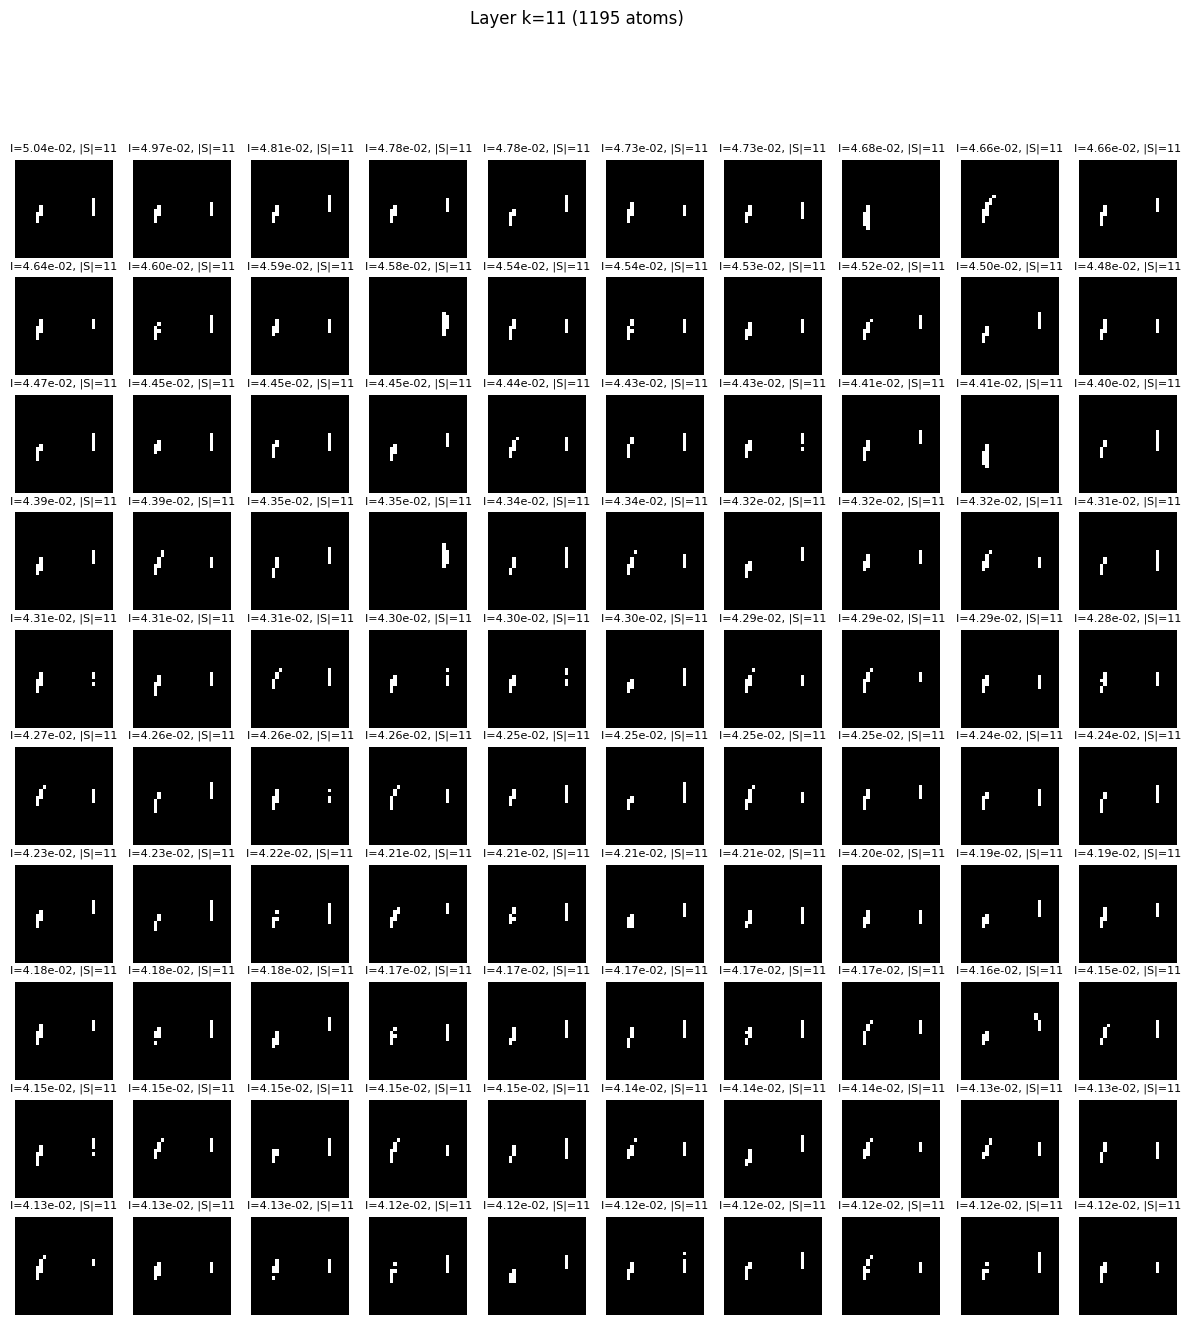

Layer k=11 has no atoms fully in the bottom region.
Result: 1195 atoms selected. KL=0.000000


In [33]:
prev_layer=layers[8]

layer_params = {
    9: dict(sigma=1e-2, tau=5e-2), 
    10: dict(sigma=5e-2, tau=1e-2),
    11: dict(sigma=1e-2, tau=5e-3),
    12: dict(sigma=1e-3, tau=5e-3),
    13: dict(sigma=1e-3, tau=5e-3),
    14: dict(sigma=1e-4, tau=1e-4),
    15: dict(sigma=1e-4, tau=1e-4),
    16: dict(sigma=1e-4, tau=1e-4),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(9,12):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    prev_layer = layer
    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint(f"checkpoint_{k}.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        


    


--- Building Layer k=12 ---
k=12 | Candidates: 2012
k=12 | After freq prune: 2012
k=12 | After spatial prune: 2012
J Stats: Max=0.0427, Median=0.0278
k=12 | Adaptive tau set to median: 5.0000e-03


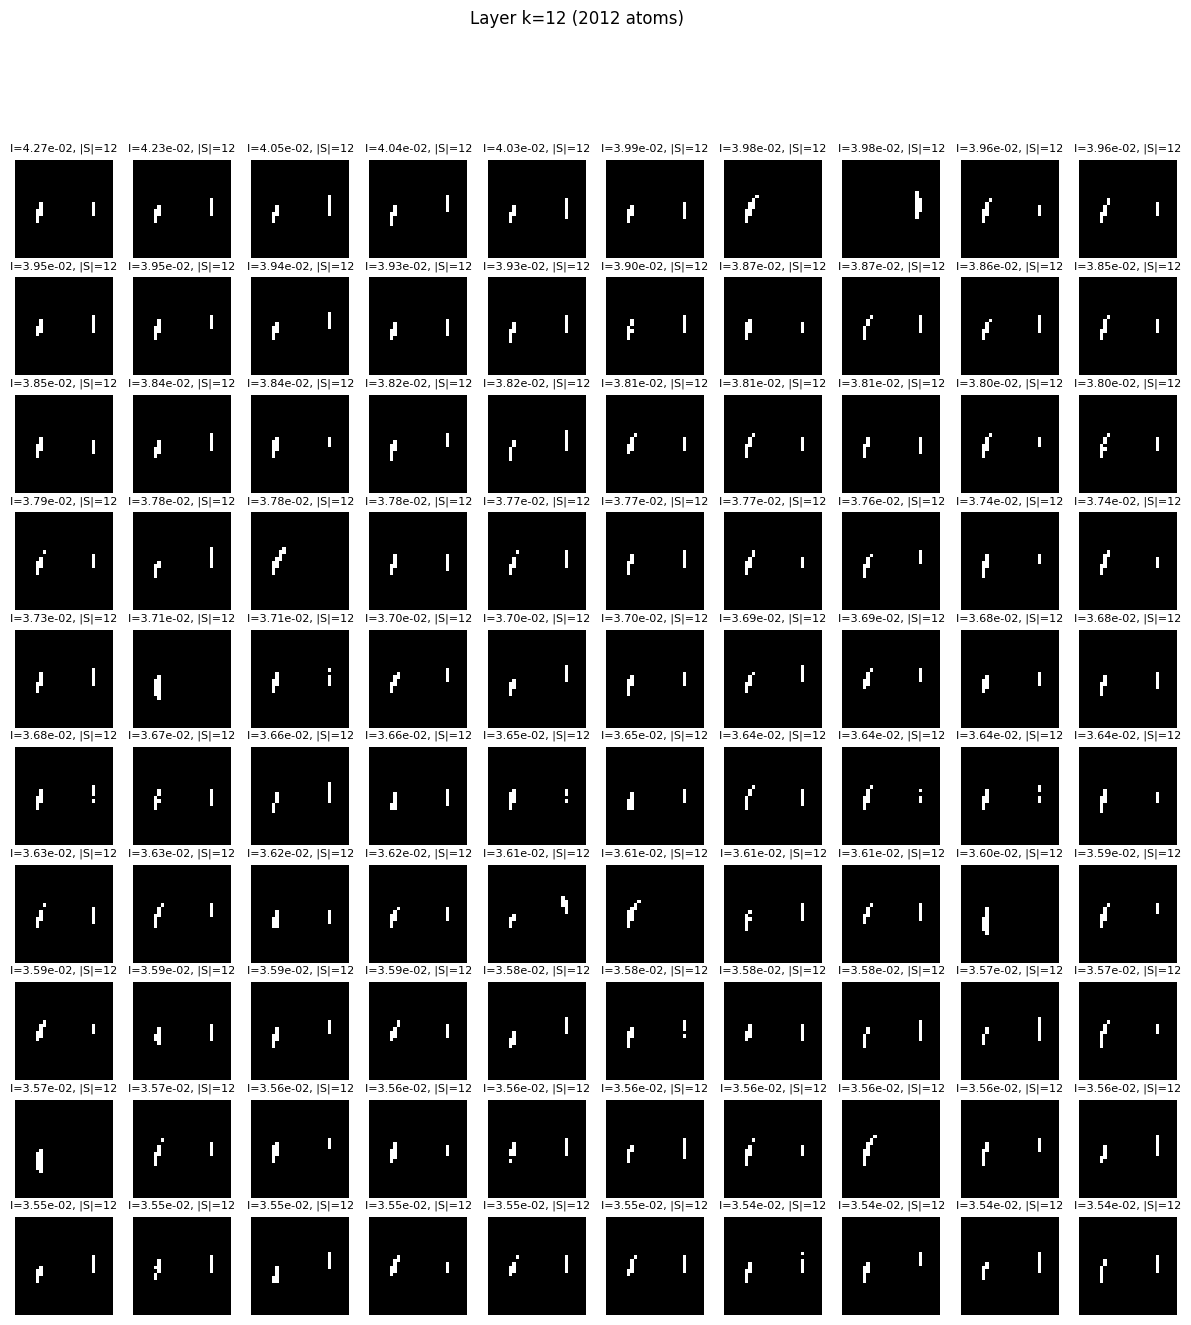

Layer k=12 has no atoms fully in the bottom region.
Result: 2012 atoms selected. KL=0.000000

--- Building Layer k=13 ---
k=13 | Candidates: 3139
k=13 | After freq prune: 3139
k=13 | After spatial prune: 3139
J Stats: Max=0.0361, Median=0.0214
k=13 | Adaptive tau set to median: 5.0000e-03


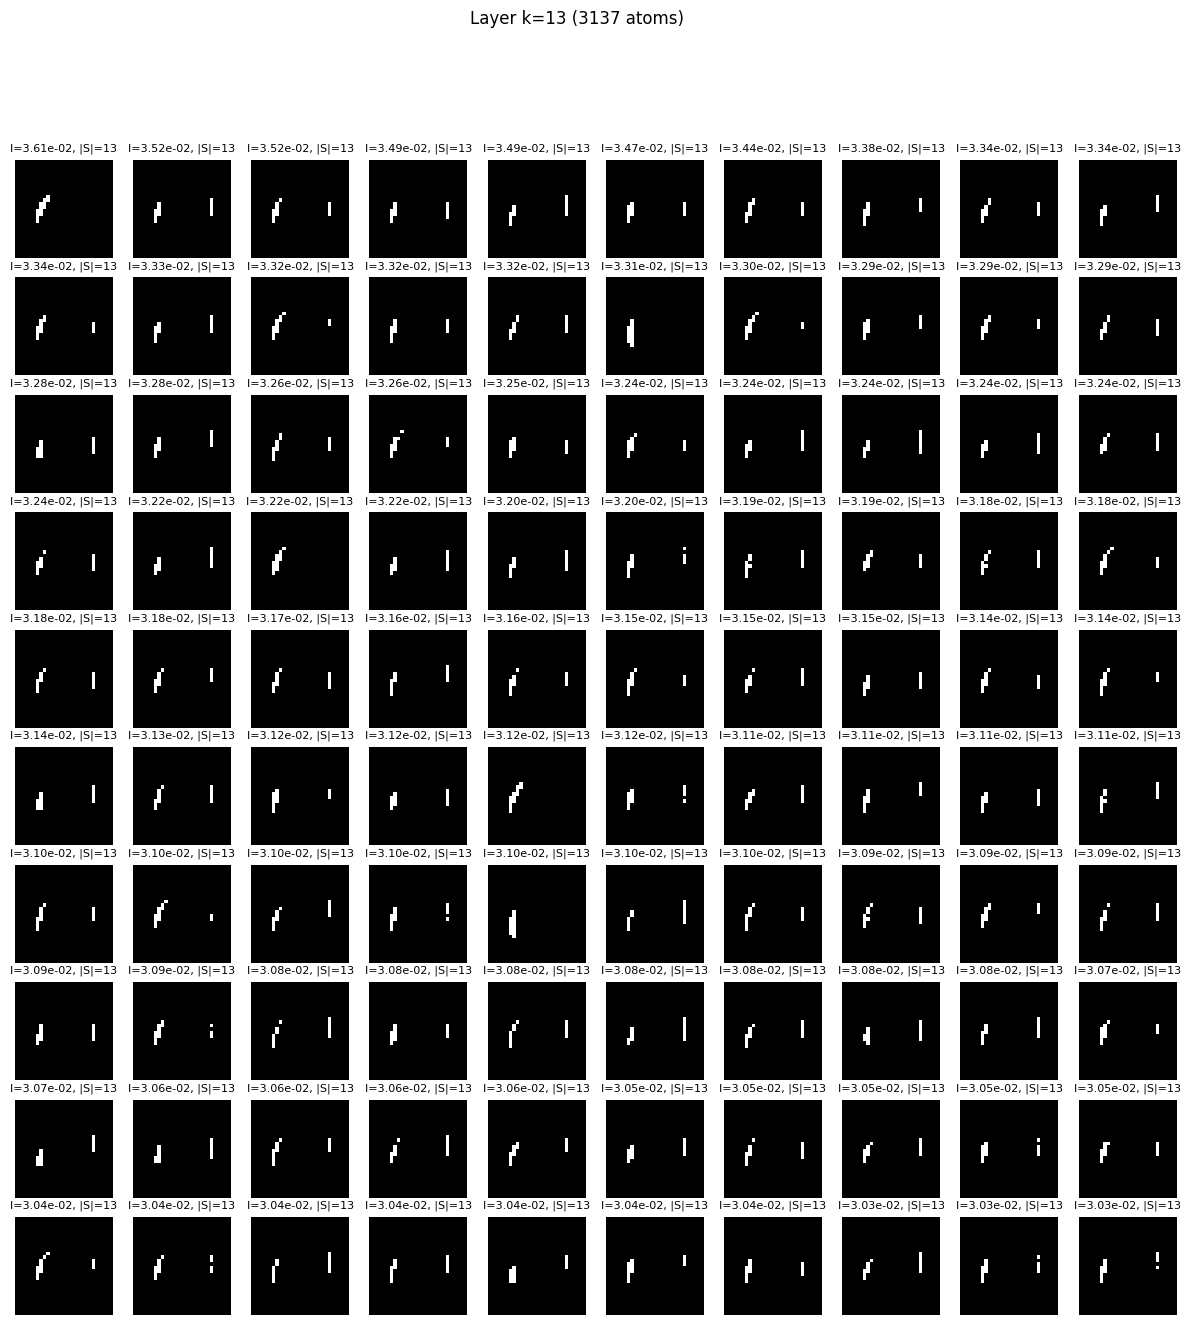

Layer k=13 has no atoms fully in the bottom region.
Result: 3137 atoms selected. KL=0.000000


In [37]:
prev_layer=layers[11]

layer_params = {
    12: dict(sigma=1e-2, tau=5e-3),
    13: dict(sigma=1e-3, tau=5e-3),
    14: dict(sigma=1e-4, tau=1e-4),
    15: dict(sigma=1e-4, tau=1e-4),
    16: dict(sigma=1e-4, tau=1e-4),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(12,14):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    prev_layer = layer
    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint(f"checkpoint_{k}.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        


    


--- Building Layer k=14 ---
ERROR! Session/line number was not unique in database. History logging moved to new session 31
k=14 | Candidates: 4560
k=14 | After freq prune: 4560
k=14 | After spatial prune: 4560
J Stats: Max=0.0317, Median=0.0161
k=14 | Adaptive tau set to median: 1.0000e-04


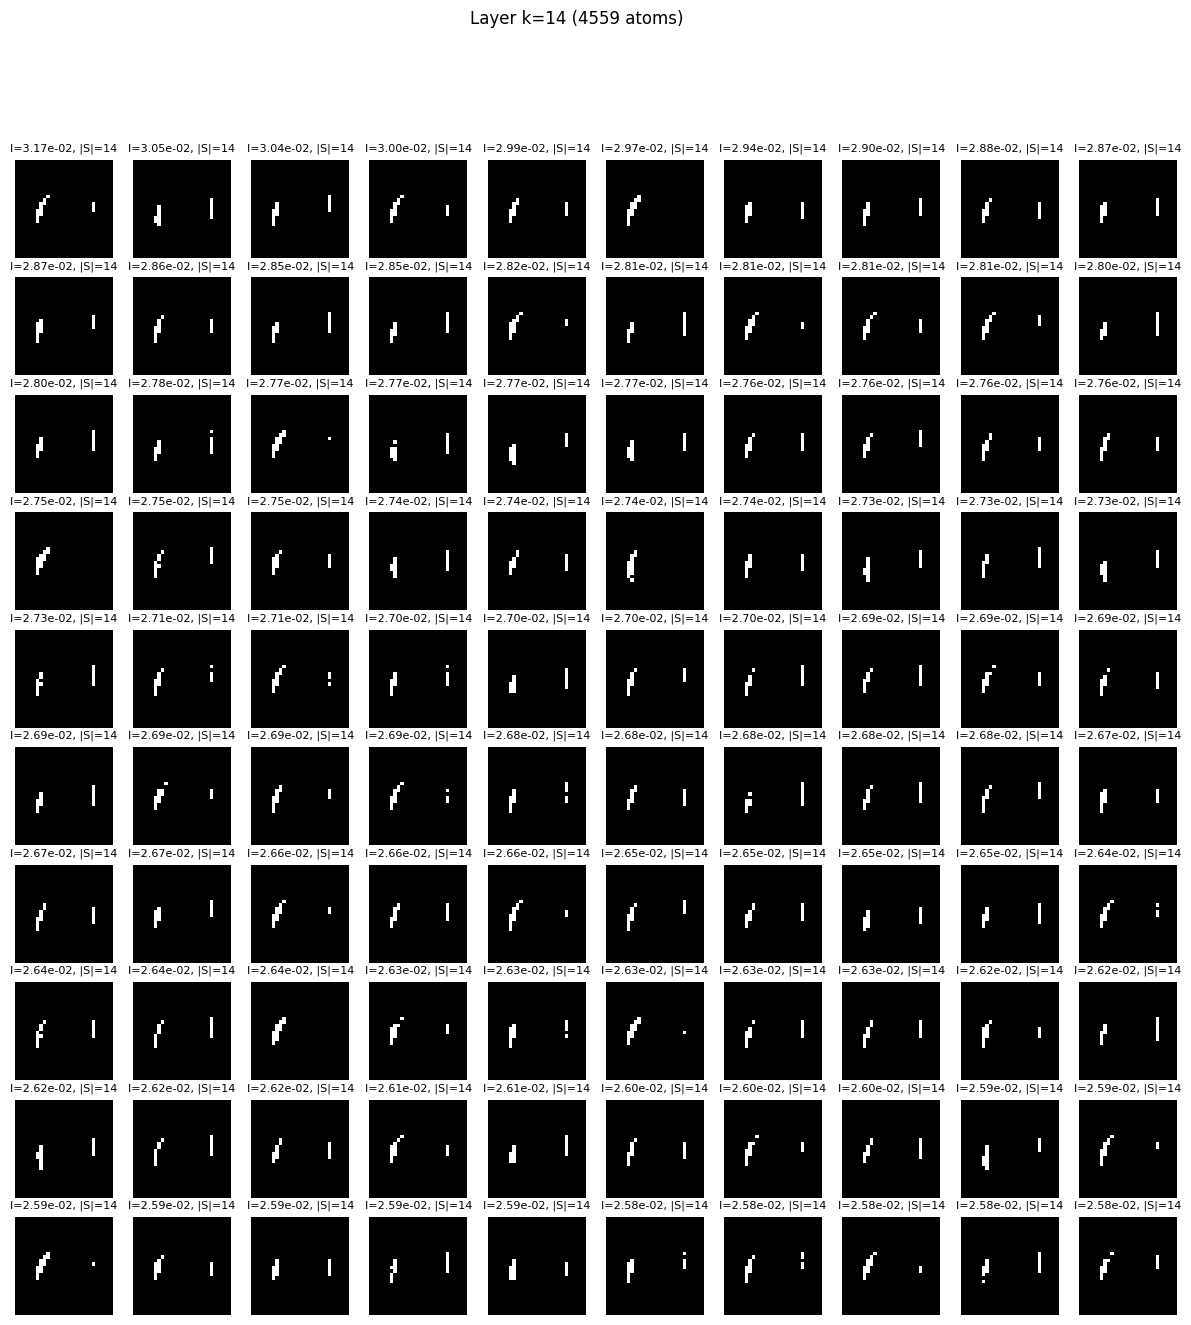

Layer k=14 has no atoms fully in the bottom region.
Result: 4559 atoms selected. KL=0.000000


In [38]:
prev_layer=layers[13]

layer_params = {
    14: dict(sigma=1e-4, tau=1e-4),
    15: dict(sigma=1e-4, tau=1e-4),
    16: dict(sigma=1e-4, tau=1e-4),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(14,15):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    prev_layer = layer
    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint(f"checkpoint_{k}.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        


    

In [22]:
prev_layer=layers[14]

layer_params = {
    14: dict(sigma=1e-4, tau=1e-4),
    15: dict(sigma=1e-4, tau=1e-4),
    16: dict(sigma=1e-4, tau=1e-4),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(15,16):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    prev_layer = layer
    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint(f"checkpoint_{k}.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        


    

KeyError: 14

In [31]:
for k in range(1,10):
    layer = layers[k]
    save_checkpoint(f"03_checkpoint_{k}.pkl", k, layer, p_emp, d,X)

In [23]:
ckpt = load_checkpoint("/kaggle/working/checkpoint_14.pkl")
prev_layer = Layer(
    k=ckpt["k"],
    sigma=0.0,      # not used anymore
    tau=0.0,
    prev_layer=None,
    d=ckpt["d"]
)

prev_layer.atoms = ckpt["atoms"]
prev_layer.q = ckpt["q"]

X = ckpt["X"]
print(X)
states, counts = np.unique(X, axis=0, return_counts=True)
p_emp = ckpt["p_emp"]

lazy_marginals = LazyMarginals(states)
entropy_cache  = EntropyCache(X)
support_cache  = SupportCache(X)


X_gpu = cp.asarray(X, dtype=cp.int8)
d=X.shape[1]

build_kwargs = dict(
    X_gpu=X_gpu,
    states=states,
    p_emp=p_emp,
    lazy_marginals=lazy_marginals,
    entropy_cache=entropy_cache,
    support_cache=support_cache,
)



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
layers={f"{ckpt['k']}": prev_layer}


--- Building Layer k=15 ---
k=15 | Candidates: 6149
k=15 | After freq prune: 1878
k=15 | After spatial prune: 1878
J Stats: Max=0.0269, Median=0.0138
k=15 | Adaptive tau set to median: 5.0000e-03
Result: 1798 atoms selected. KL=0.000000


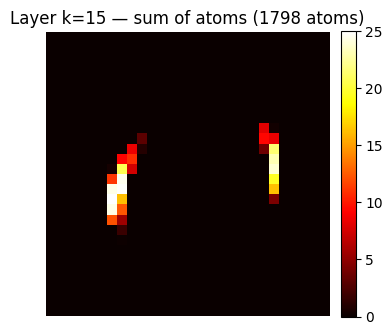


--- Building Layer k=16 ---
k=16 | Candidates: 3004
k=16 | After freq prune: 3004
k=16 | After spatial prune: 3004


In [ ]:
layer_params = {
    15: dict(sigma=4e-2, tau=5e-3),
    16: dict(sigma=1e-4, tau=1e-4),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}



for k in range(15,17):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    
    
    prev_layer = layer

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")
    plot_layer_atom_sum(layers, k)

    save_checkpoint(f"checkpoint{k}.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        


    

In [4]:
ckpt = load_checkpoint("/kaggle/input/chkpoint/checkpoint (7).pkl")
prev_layer = Layer(
    k=ckpt["k"],
    sigma=0.0,      # not used anymore
    tau=0.0,
    prev_layer=None,
    d=ckpt["d"]
)

prev_layer.atoms = ckpt["atoms"]
prev_layer.q = ckpt["q"]

X = ckpt["X"]
print(X)
states, counts = np.unique(X, axis=0, return_counts=True)
p_emp = ckpt["p_emp"]

lazy_marginals = LazyMarginals(states)
entropy_cache  = EntropyCache(X)
support_cache  = SupportCache(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
X_gpu = cp.asarray(X, dtype=cp.int8)
d=X.shape[1]

In [6]:
build_kwargs = dict(
    X_gpu=X_gpu,          # changed
    states=states,
    p_emp=p_emp,
    lazy_marginals=lazy_marginals,
    entropy_cache=entropy_cache,
    support_cache=support_cache,
)


In [7]:
prev_layer.k

14


--- Building Layer k=15 ---
k=15 | Candidates: 9328
k=15 | After freq prune: 954
k=15 | After spatial prune: 954
J Stats: Max=0.0188, Median=0.0047
k=15 | Adaptive tau set to median: 1.0000e-03


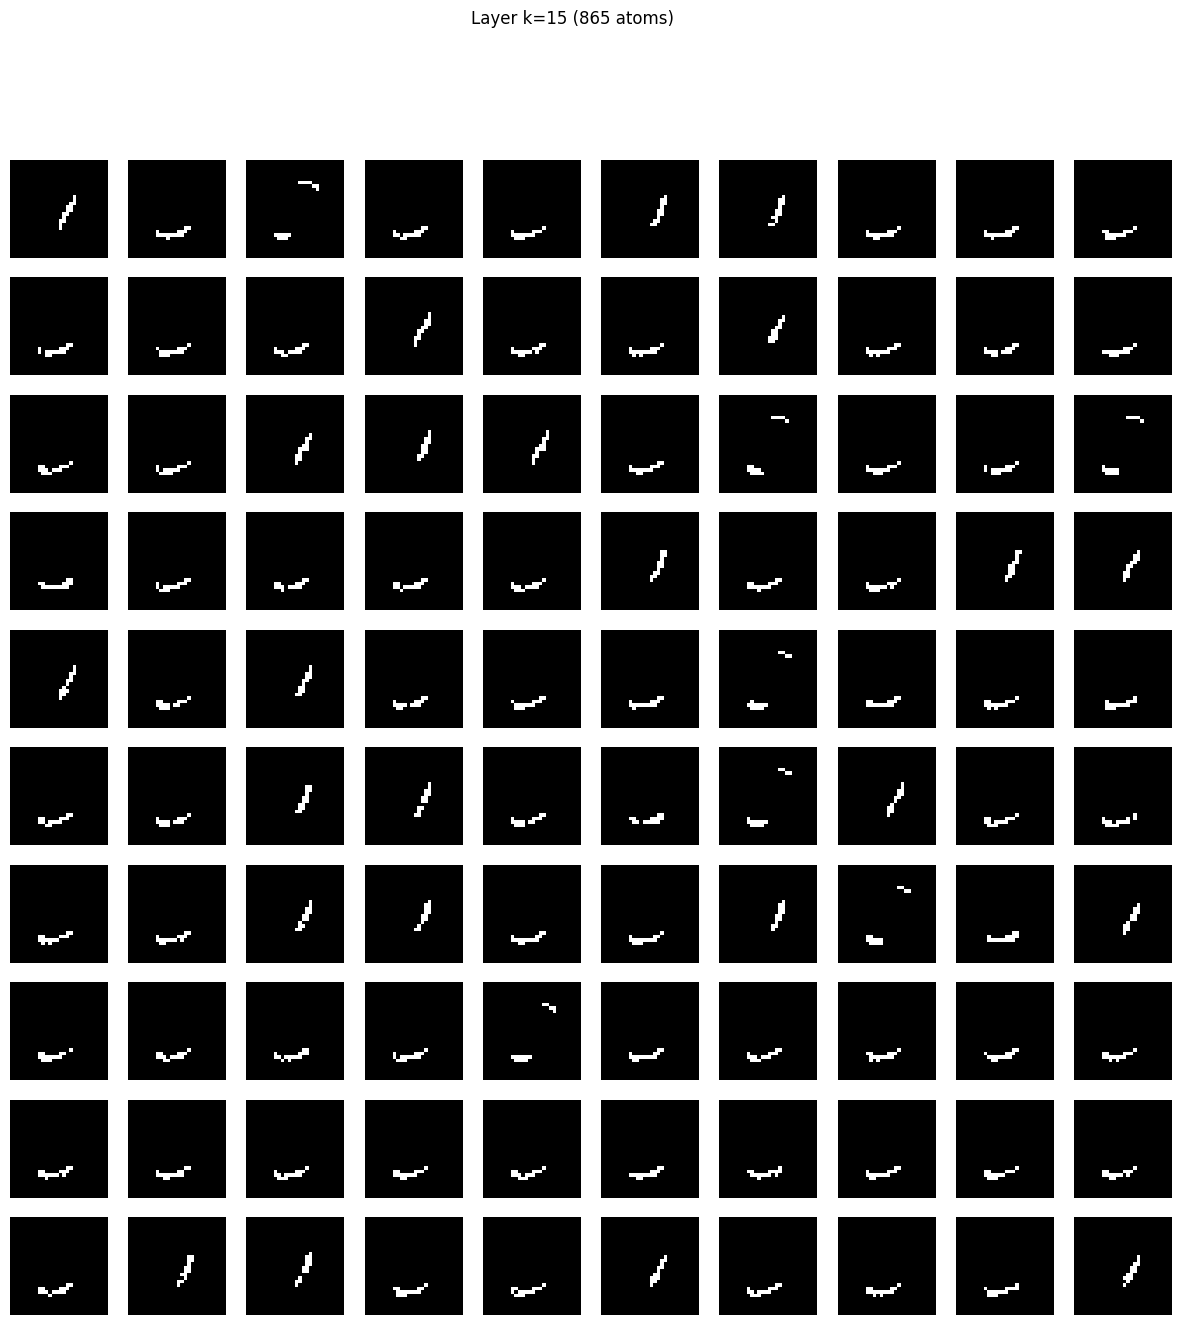

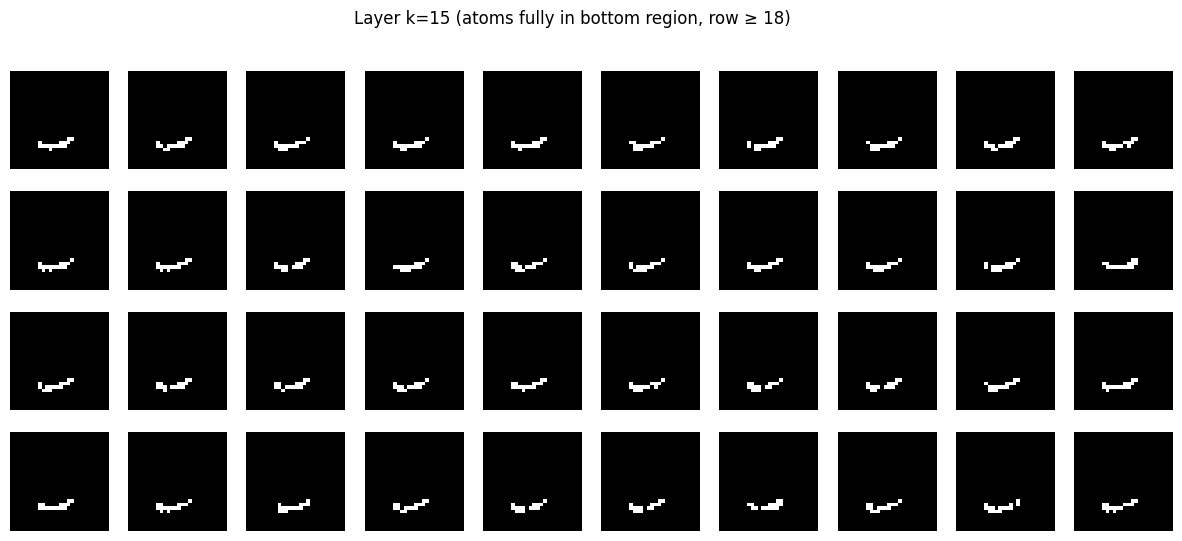

Result: 865 atoms selected. KL=0.000000


In [8]:
layers={}
layer_params = {
    15: dict(sigma=4e-2, tau=1e-3),
    16: dict(sigma=1e-4, tau=1e-4),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(15,16):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint("checkpoint.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer




--- Building Layer k=16 ---
k=16 | Candidates: 873
k=16 | After freq prune: 873
k=16 | After spatial prune: 873
J Stats: Max=0.0213, Median=0.0040
k=16 | Adaptive tau set to median: 1.0000e-03


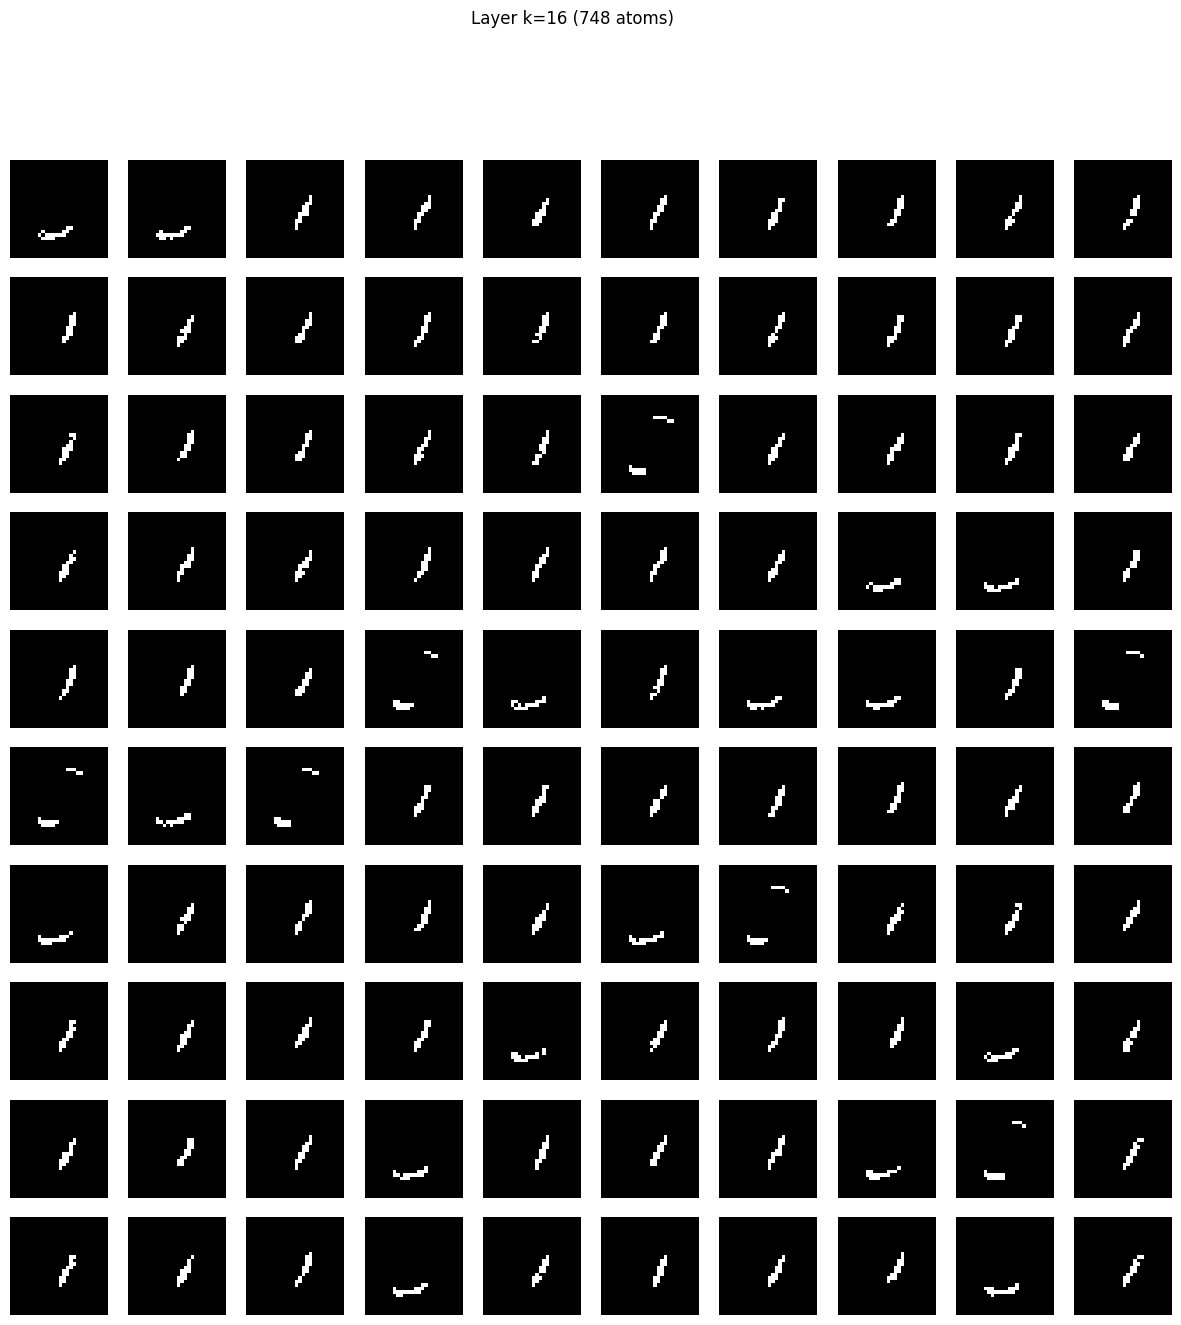

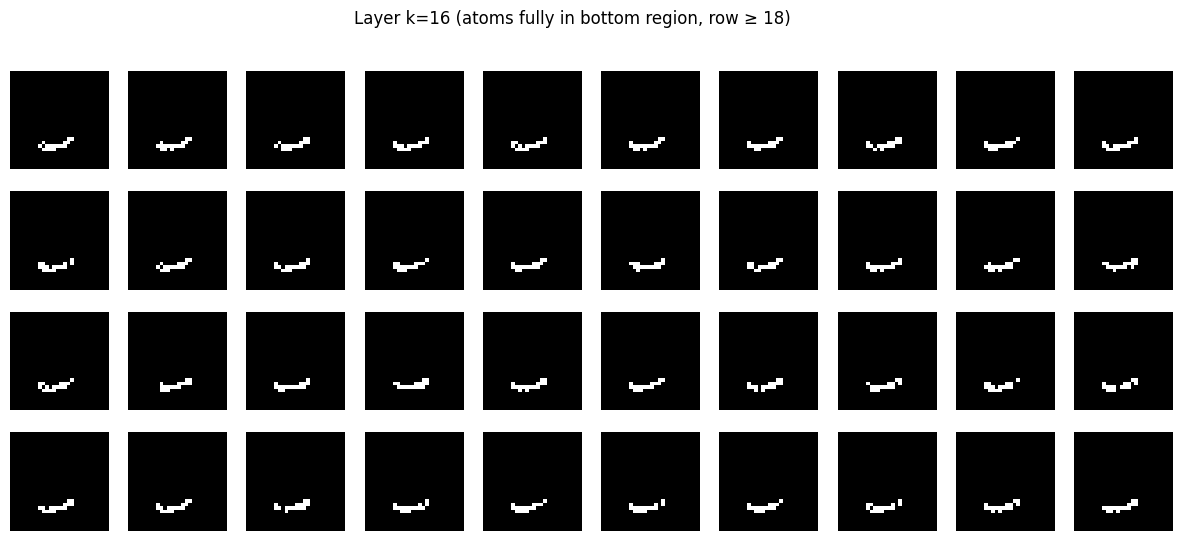

Result: 748 atoms selected. KL=0.000000


In [9]:
prev_layer=layers[15]
layer_params = {
    16: dict(sigma=1e-2, tau=1e-3),
    17: dict(sigma=1e-4, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(16,17):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint("checkpoint.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer




--- Building Layer k=17 ---
k=17 | Candidates: 664
k=17 | After freq prune: 664
k=17 | After spatial prune: 664
J Stats: Max=0.0261, Median=0.0064
k=17 | Adaptive tau set to median: 1.0000e-04


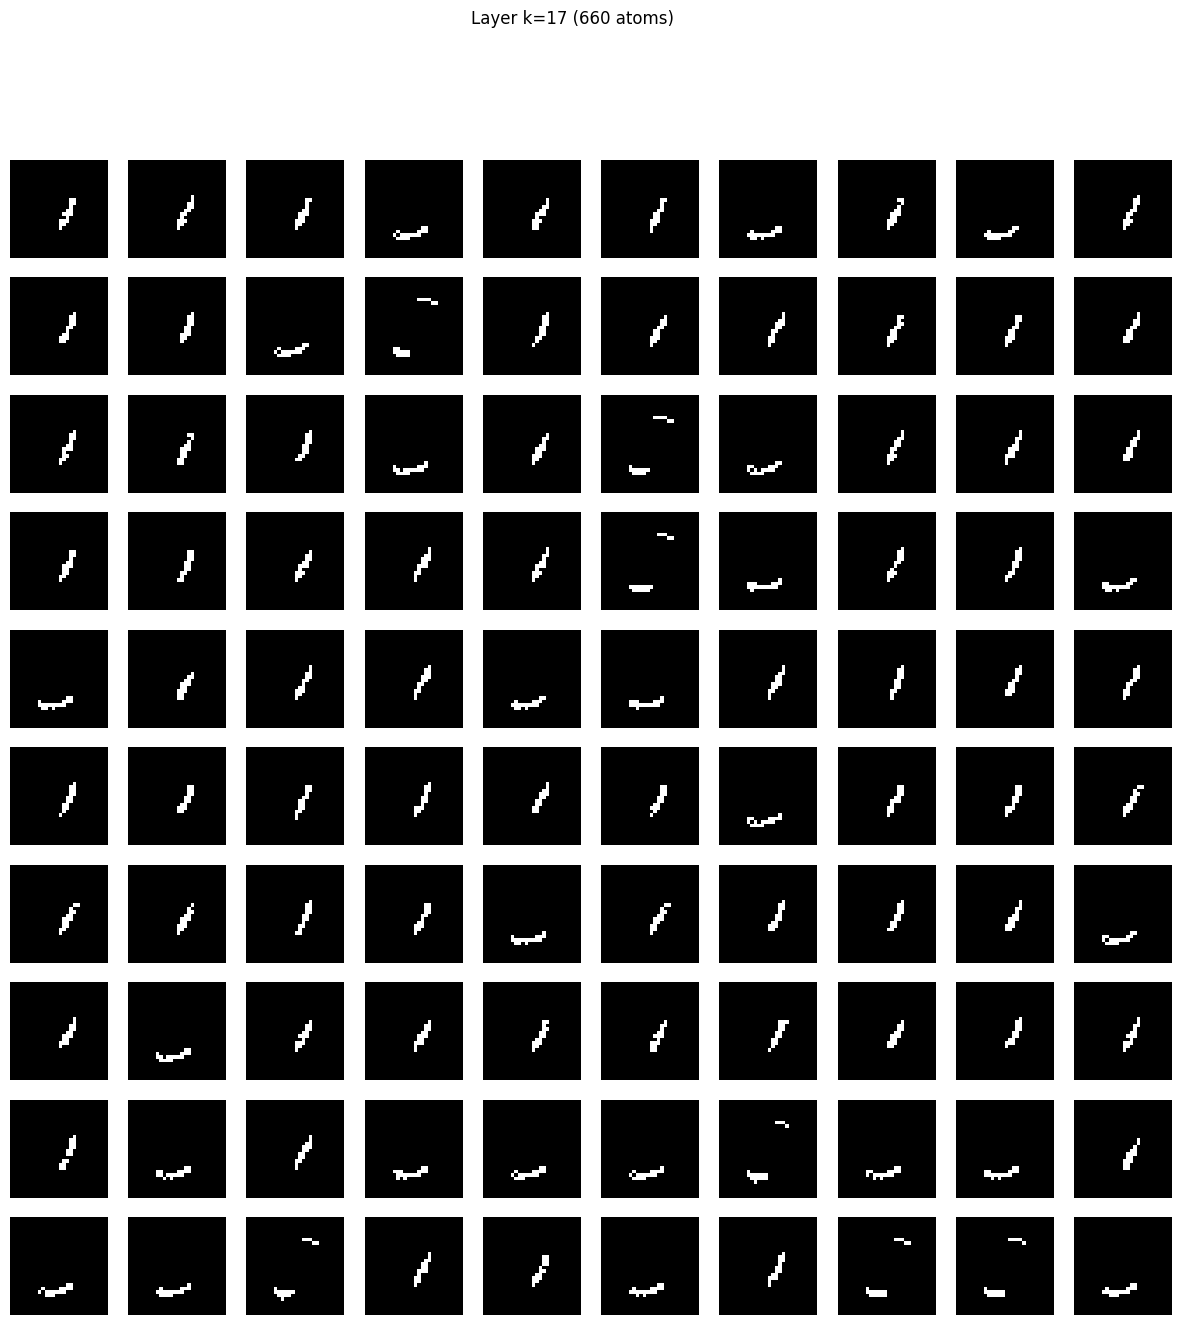

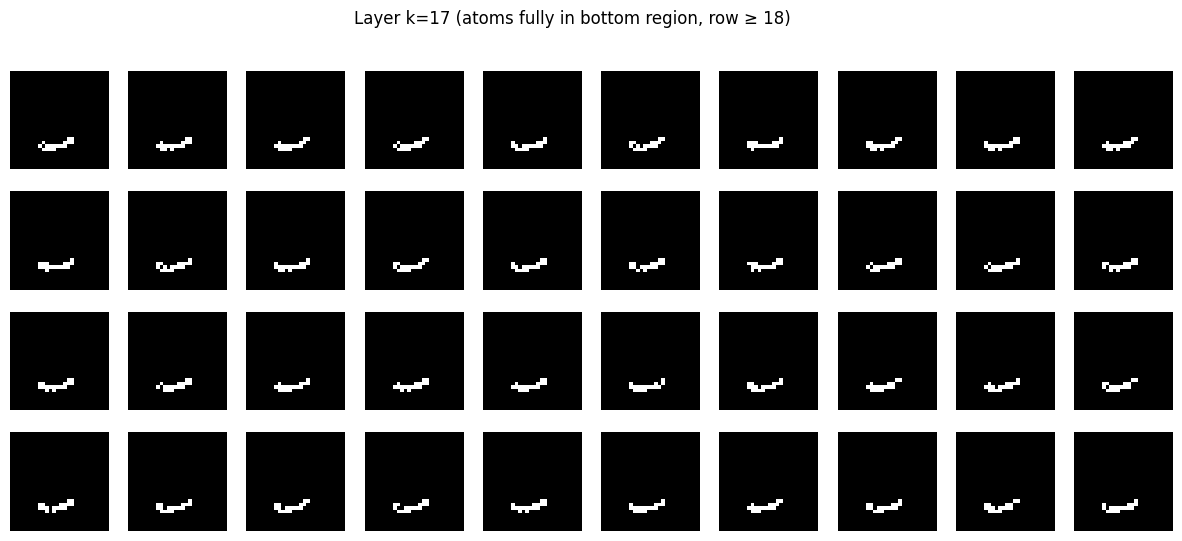

Result: 660 atoms selected. KL=0.000000


In [10]:
prev_layer=layers[16]
layer_params = {
    17: dict(sigma=1e-2, tau=1e-4),
    18: dict(sigma=1e-4, tau=1e-4),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(17,18):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint("checkpoint.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer




--- Building Layer k=18 ---
k=18 | Candidates: 480
k=18 | After freq prune: 480
k=18 | After spatial prune: 480
J Stats: Max=0.0297, Median=0.0092
k=18 | Adaptive tau set to median: 1.0000e-02


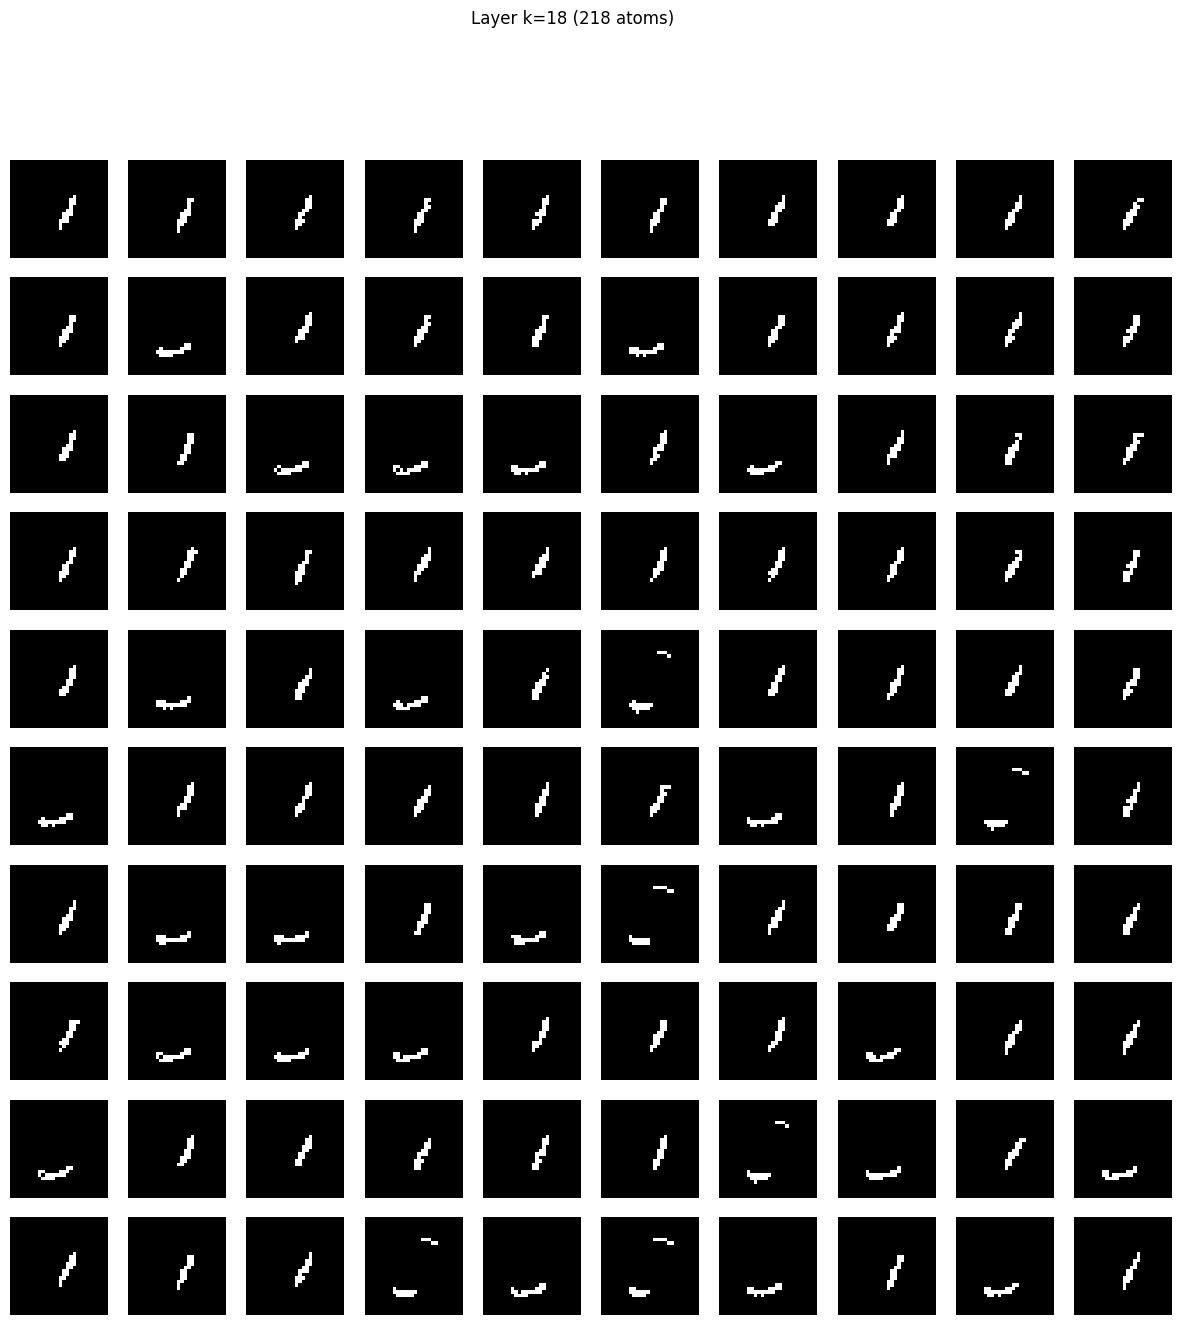

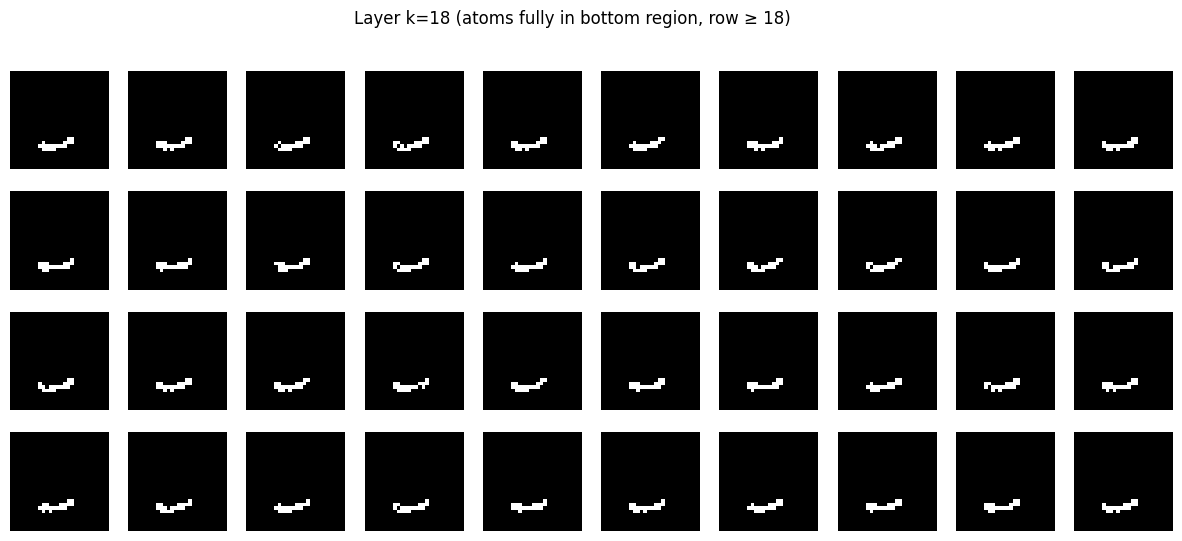

Result: 218 atoms selected. KL=0.000000


In [11]:
prev_layer=layers[17]
layer_params = {
    18: dict(sigma=1e-3, tau=1e-2),
    19: dict(sigma=1e-4, tau=1e-4),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(18,19):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint("checkpoint.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer




--- Building Layer k=19 ---
k=19 | Candidates: 185
k=19 | After freq prune: 185
k=19 | After spatial prune: 185
J Stats: Max=0.0319, Median=0.0132
k=19 | Adaptive tau set to median: 1.0000e-03


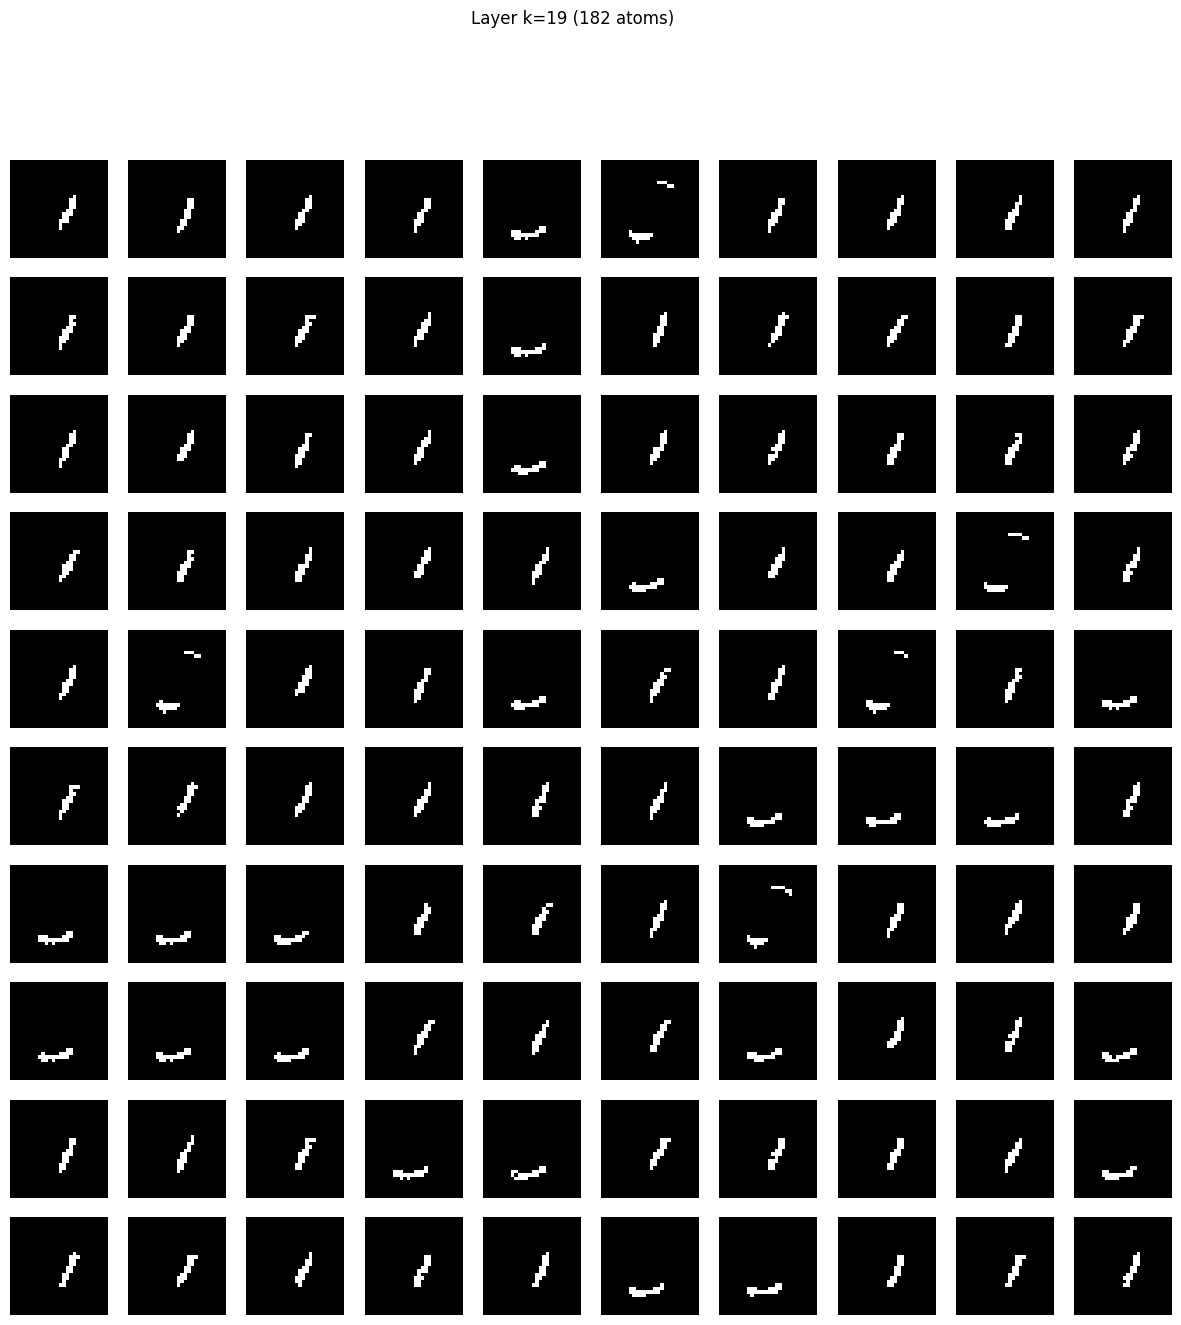

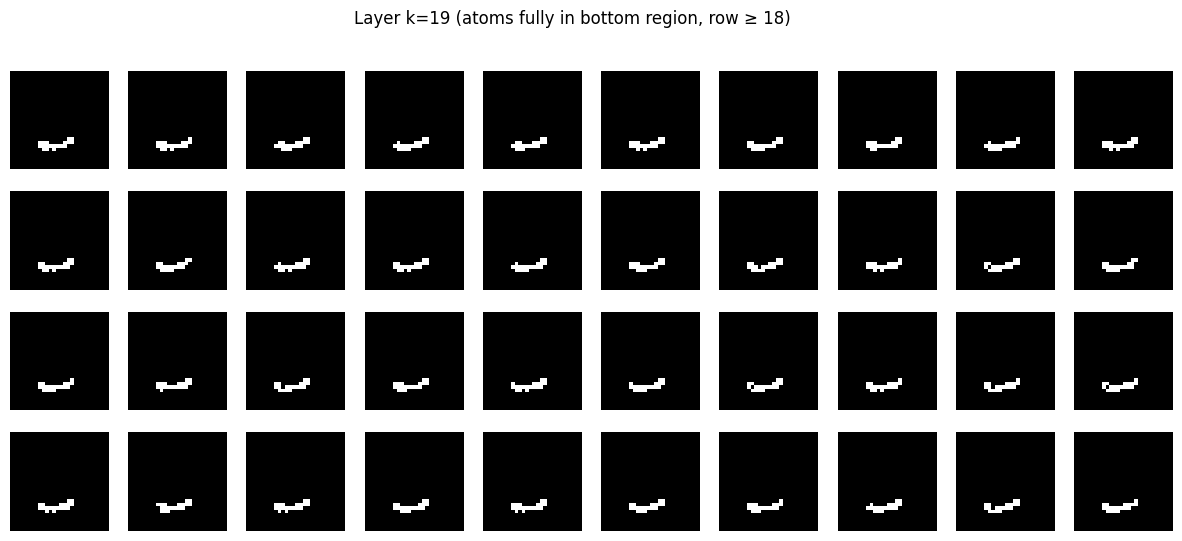

Result: 182 atoms selected. KL=0.000000


In [12]:
prev_layer=layers[18]
layer_params = {
    19: dict(sigma=1e-3, tau=1e-3),
    20: dict(sigma=1e-4, tau=1e-4),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(19,20):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint("checkpoint.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer



In [ ]:
prev_layer=layers[19]
layer_params = {
    20: dict(sigma=1e-2, tau=1e-2),
    21: dict(sigma=1e-4, tau=1e-4),
}

for k in range(20,21):
    params = layer_params[k]
    
    print(f"\n--- Building Layer k={k} ---")
    layer = Layer(
        k=k,
        sigma=params["sigma"],
        tau=params["tau"],
        prev_layer=prev_layer,
        d=d if prev_layer is None else None
    ).build(**build_kwargs)

    layers[k] = layer
    plot_layer_atoms(layers, k,max_atoms=100) 
    plot_layer_atoms_bottom(layers, k)
    
    

    
    print(f"Result: {len(layer.atoms)} atoms selected. KL={KL(p_emp, layer.q):.6f}")

    save_checkpoint("checkpoint.pkl", k, prev_layer, p_emp, d,X)

    if len(layer.atoms) == 0:
        print("Stopping early (no atoms).")
        break
        
    prev_layer = layer




--- Building Layer k=20 ---
k=20 | Candidates: 133
k=20 | After freq prune: 133
k=20 | After spatial prune: 133
